In [1536]:
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from scipy.stats import chi2_contingency
import xgboost as xgb
import optuna
import numpy as np 
from tqdm.notebook import tqdm
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import random


rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

palette = ['#302c36', '#037d97', '#91013E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore

blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# Dataset

In [1537]:
root = "dr_pineda.csv"
raw_data = pd.read_csv(root)
raw_data.head()

,Group,Gender,Age (y),Schooling (y),Breastfeeding,Varicella,initial symptom,Mono or polysymptomatic,Oligoclonal bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular MRI,Cortical MRI,Infratentorial MRI,Spinal cord MRI,initial EDSS,final EDSS
0,1,1,34,20.0,1,1,2,1,0,1,1,0,0,0,1,0,1,1.0,1.0
1,1,1,61,25.0,3,2,10,2,1,1,0,1,0,0,0,0,1,2.0,2.0
2,1,1,22,20.0,3,1,3,1,1,0,0,0,0,0,1,0,0,1.0,1.0
3,1,2,41,15.0,1,1,7,2,1,0,1,1,0,1,1,0,0,1.0,1.0
4,1,2,34,20.0,2,1,6,2,0,1,0,0,0,1,0,0,0,1.0,1.0


### EDA

In [1538]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Group                    273 non-null    int64  
 1   Gender                   273 non-null    int64  
 2   Age (y)                  273 non-null    int64  
 3   Schooling (y)            272 non-null    float64
 4   Breastfeeding            273 non-null    int64  
 5   Varicella                273 non-null    int64  
 6   initial symptom          273 non-null    int64  
 7   Mono or polysymptomatic  273 non-null    int64  
 8   Oligoclonal bands        273 non-null    int64  
 9   LLSSEP                   273 non-null    int64  
 10  ULSSEP                   273 non-null    int64  
 11  VEP                      273 non-null    int64  
 12  BAEP                     273 non-null    int64  
 13  Periventricular MRI      273 non-null    int64  
 14  Cortical MRI             2

##### Missed values

In [1539]:
raw_data.columns

Index(['Group', 'Gender', 'Age (y)', 'Schooling (y)', 'Breastfeeding',
       'Varicella', 'initial symptom', 'Mono or polysymptomatic',
       'Oligoclonal bands', 'LLSSEP', 'ULSSEP', 'VEP', 'BAEP',
       'Periventricular MRI', 'Cortical MRI', 'Infratentorial MRI',
       'Spinal cord MRI', 'initial EDSS', ' final EDSS'],
      dtype='object')

In [1540]:
raw_data.isna().sum()

Group                        0
Gender                       0
Age (y)                      0
Schooling (y)                1
Breastfeeding                0
Varicella                    0
initial symptom              0
Mono or polysymptomatic      0
Oligoclonal bands            0
LLSSEP                       0
ULSSEP                       0
VEP                          0
BAEP                         0
Periventricular MRI          0
Cortical MRI                 0
Infratentorial MRI           0
Spinal cord MRI              0
initial EDSS               148
 final EDSS                148
dtype: int64

In [1541]:
# Demographics
demographics_cols = ['Group', 'Gender', 'Age (y)', 'Schooling (y)', 'Breastfeeding']

# Clinical
clinical_cols = ['Varicella', 'initial symptom', 'Mono or polysymptomatic', 'Oligoclonal bands', "initial EDSS", " final EDSS"]

# MRI
mri_cols = ['Periventricular MRI', 'Cortical MRI', 'Infratentorial MRI','Spinal cord MRI']

# Electrophysiology
ep_cols = ['LLSSEP', 'ULSSEP', 'VEP', 'BAEP']

##### Group

In [1542]:
raw_data["Group"] = raw_data["Group"].map({
    1: "CDMS",
    2: "non-CDMS"
})

In [1543]:
raw_data["ID"] = raw_data.index

In [1544]:
raw_data["ID"].unique().size

273

### Demographics

In [1545]:
demo_data = raw_data[["ID"] + demographics_cols].copy()
demo_data.head()

,ID,Group,Gender,Age (y),Schooling (y),Breastfeeding
0,0,CDMS,1,34,20.0,1
1,1,CDMS,1,61,25.0,3
2,2,CDMS,1,22,20.0,3
3,3,CDMS,2,41,15.0,1
4,4,CDMS,2,34,20.0,2


##### Missing Values

In [1546]:
demo_data.isna().sum()

ID               0
Group            0
Gender           0
Age (y)          0
Schooling (y)    1
Breastfeeding    0
dtype: int64

In [1547]:
# Fill the missed value with the most frequent value
# demo_data["Schooling (y)"].fillna(demo_data["Schooling (y)"].mode(), inplace=True)

##### Gender

In [1548]:
demo_data["Gender"] = demo_data["Gender"].map({
    1: "Male",
    2: "Female"
})

##### Schooling

In [1549]:
demo_data["Schooling (y)"].value_counts()

Schooling (y)
20.0    83
15.0    81
12.0    59
9.0     34
22.0     4
6.0      3
25.0     2
14.0     2
0.0      1
23.0     1
24.0     1
8.0      1
Name: count, dtype: int64

In [1550]:
# Categorizing schooling column values to 4 categories
def schooling(sch):
    if sch < 15:
        return "< 15 (y)"
    elif sch >= 15 :
        return "≥ 15 (y)"
    
demo_data["Schooling (y)"] = demo_data["Schooling (y)"].apply(lambda sch: schooling(sch))
demo_data["Schooling (y)"].value_counts()

Schooling (y)
≥ 15 (y)    172
< 15 (y)    100
Name: count, dtype: int64

In [1551]:
demo_data[["Schooling (y)", "Group"]].value_counts().to_frame(name="counts").reset_index().sort_values('Schooling (y)', ascending=True)

,Schooling (y),Group,counts
2,< 15 (y),non-CDMS,69
3,< 15 (y),CDMS,31
0,≥ 15 (y),CDMS,94
1,≥ 15 (y),non-CDMS,78


##### Age

In [1552]:
age_stats = demo_data["Age (y)"].agg(['mean', 'std'])
print(f"Age: {age_stats['mean']:0.2f}±{age_stats['std']:0.2f}")

Age: 34.06±11.11


In [1553]:
# Calculate mean and std
age_stats = demo_data.groupby(["Group"])["Age (y)"].agg(['mean', 'std'])

# Format as "mean+-std"
age_stats['Mean±Std Age (y)'] = age_stats.apply(lambda row: f"{row['mean']:.1f}±{row['std']:.1f}", axis=1)

# Drop the original 'mean' and 'std' columns
age_stats = age_stats.drop(columns=['mean', 'std'])

age_stats

,Mean±Std Age (y)
Group,
CDMS,34.8±11.4
non-CDMS,33.4±10.8


In [1554]:
def age_group(age):
    if age < 30:
        return "< 30 (y)"
    else:
        return "≥ 30 (y)"
    
demo_data["Age Group"] = demo_data["Age (y)"].apply(age_group)

In [1555]:
demo_data[["Group", "Age Group"]].value_counts()

Group     Age Group
non-CDMS  ≥ 30 (y)     86
CDMS      ≥ 30 (y)     78
non-CDMS  < 30 (y)     62
CDMS      < 30 (y)     47
Name: count, dtype: int64

In [1556]:
# Mean Age
demo_data.groupby(['Gender', "Group"])["Age (y)"].mean().to_frame(name="Mean Age (y)").round(1)

Mean Age (y)
Gender Group                 
Female CDMS              35.4
       non-CDMS          34.3
Male   CDMS              34.3
       non-CDMS          31.0

##### Breastfeeding

In [1557]:
demo_data.rename(columns={"Breastfeeding": "Breastfeeding History"}, inplace=True)

In [1558]:
demo_data["Breastfeeding History"] = demo_data["Breastfeeding History"].map({
    1: "Yes",
    2: "No",
})

In [1559]:
for col in demo_data.columns:
    missed_size = (demo_data[col].isna().sum() / len(demo_data)) * 100
    print(f"Column: {col} | Missed Percentage: {missed_size: 0.2f}%")
    
    if missed_size >= 50:
        demo_data.drop(columns=[col], inplace=True)
        print(f"Dropped!")
        
    print("------------------")

Column: ID | Missed Percentage:  0.00%
------------------
Column: Group | Missed Percentage:  0.00%
------------------
Column: Gender | Missed Percentage:  0.00%
------------------
Column: Age (y) | Missed Percentage:  0.00%
------------------
Column: Schooling (y) | Missed Percentage:  0.37%
------------------
Column: Breastfeeding History | Missed Percentage:  31.14%
------------------
Column: Age Group | Missed Percentage:  0.00%
------------------


In [1560]:
demo_data[["Group", "Gender"]].value_counts()

Group     Gender
non-CDMS  Female    107
CDMS      Male       64
          Female     61
non-CDMS  Male       41
Name: count, dtype: int64

##### Final Demographics Data

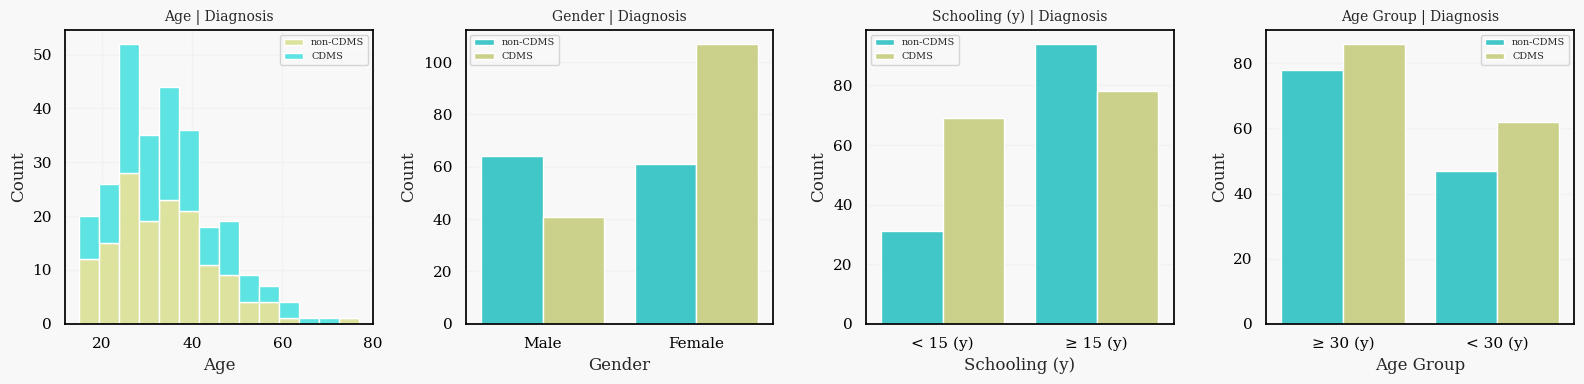

In [1561]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(data=demo_data, x="Age (y)", hue="Group", ax=ax[0], multiple="stack", palette='rainbow')
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Count")
ax[0].set_title("Age | Diagnosis", fontsize=10)
ax[0].legend(["non-CDMS", "CDMS"], prop={'size': 7})

sns.countplot(data=demo_data, x="Gender", hue="Group",ax=ax[1], palette="rainbow")
ax[1].set_xlabel("Gender")
ax[1].set_ylabel("Count")
ax[1].set_title("Gender | Diagnosis", fontsize=10)
ax[1].legend(["non-CDMS", "CDMS"],  prop={'size': 7})

order = sorted(demo_data['Schooling (y)'].dropna().unique())
sns.countplot(data=demo_data, x="Schooling (y)", hue="Group",ax=ax[2], palette="rainbow", order=order)
ax[2].set_xlabel("Schooling (y)")
ax[2].set_ylabel("Count")
ax[2].set_title("Schooling (y) | Diagnosis", fontsize=10)
ax[2].legend(["non-CDMS", "CDMS"], prop={'size': 7})

sns.countplot(data=demo_data, x="Age Group", hue="Group",ax=ax[3], palette="rainbow")
ax[3].set_xlabel("Age Group")
ax[3].set_ylabel("Count")
ax[3].set_title("Age Group | Diagnosis", fontsize=10)
ax[3].legend(["non-CDMS", "CDMS"], prop={'size': 7})

plt.tight_layout()
plt.show()

In [1562]:
demo_data.head()

,ID,Group,Gender,Age (y),Schooling (y),Breastfeeding History,Age Group
0,0,CDMS,Male,34,≥ 15 (y),Yes,≥ 30 (y)
1,1,CDMS,Male,61,≥ 15 (y),NaN,≥ 30 (y)
2,2,CDMS,Male,22,≥ 15 (y),NaN,< 30 (y)
3,3,CDMS,Female,41,≥ 15 (y),Yes,≥ 30 (y)
4,4,CDMS,Female,34,≥ 15 (y),No,≥ 30 (y)


In [1563]:
f_demo_data = demo_data.replace({
    "non-CDMS": 0, "CDMS": 1,
    "Female": 0, "Male": 1,
    "< 15 (y)": 0, "≥ 15 (y)": 1,
    "< 30 (y)": 0, "≥ 30 (y)": 1,
    "No": 0, "Yes": 1
})

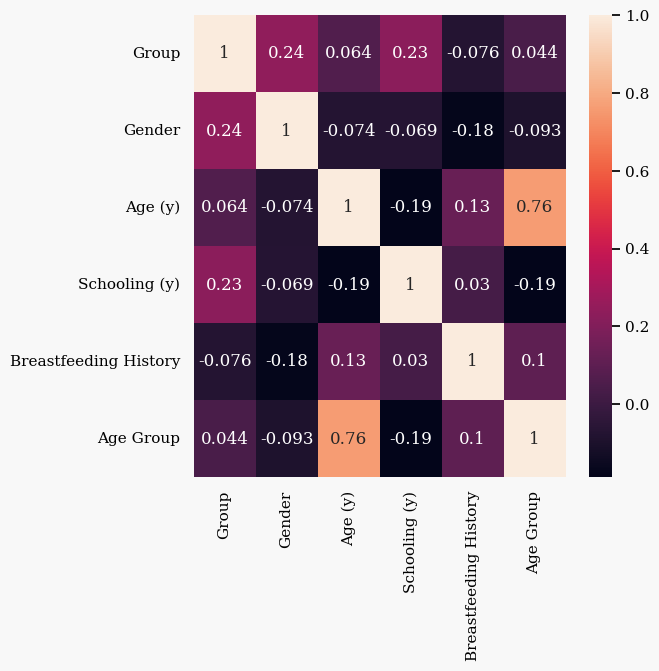

In [1564]:
corr = f_demo_data.drop(columns=["ID"]).corr()

fig = plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True)
plt.show()

### Clinical

In [1565]:
clinical_data = raw_data[["ID"] + clinical_cols + ["Group"]].copy()
clinical_data.head()

,ID,Varicella,initial symptom,Mono or polysymptomatic,Oligoclonal bands,initial EDSS,final EDSS,Group
0,0,1,2,1,0,1.0,1.0,CDMS
1,1,2,10,2,1,2.0,2.0,CDMS
2,2,1,3,1,1,1.0,1.0,CDMS
3,3,1,7,2,1,1.0,1.0,CDMS
4,4,1,6,2,0,1.0,1.0,CDMS


In [1566]:
clinical_data.isna().sum()

ID                           0
Varicella                    0
initial symptom              0
Mono or polysymptomatic      0
Oligoclonal bands            0
initial EDSS               148
 final EDSS                148
Group                        0
dtype: int64

##### Varicella

In [1567]:
clinical_data["Varicella"] = clinical_data["Varicella"].map({
    1: "Positive",
    2: "Negative"
})

clinical_data.rename(columns={"Varicella": "Varicella History"}, inplace=True)

##### Initial Symptom

In [1568]:
clinical_data["initial symptom"].value_counts()

initial symptom
8     39
3     32
1     31
4     30
2     27
6     17
10    15
14    14
5     13
15    11
13    11
11    10
7      9
9      8
12     6
Name: count, dtype: int64

In [1569]:
# Values to symptoms
initial_symptoms = ["visual", "sensory", "motor", "other", "visual and sensory", "visual and motor", "visual and other", "sensory and motor", "sensory and other", "motor and other", "visual, sensory and motor", "visual, sensory and other", "visual, motor and other", "sensory, motor and other", "visual, sensory, motor and other"]

symptom_dict = {i+1: symptom for i, symptom in enumerate(initial_symptoms)}
clinical_data["Initial Symptoms"] = clinical_data["initial symptom"].map(symptom_dict)
clinical_data.drop(columns=["initial symptom"], inplace=True)

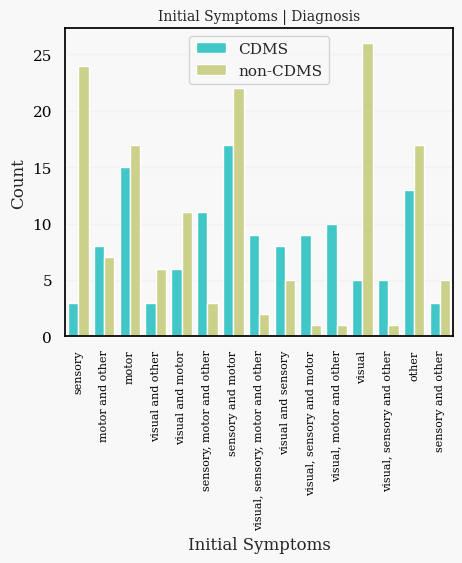

In [1570]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.countplot(data=clinical_data, x="Initial Symptoms", hue="Group",ax=ax, palette="rainbow")
ax.set_xlabel("Initial Symptoms")
ax.set_ylabel("Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_title("Initial Symptoms | Diagnosis", fontsize=10)
ax.legend(["CDMS", "non-CDMS"])

plt.show()

In [1571]:
clinical_data["Initial Symptoms"].value_counts()

Initial Symptoms
sensory and motor                   39
motor                               32
visual                              31
other                               30
sensory                             27
visual and motor                    17
motor and other                     15
sensory, motor and other            14
visual and sensory                  13
visual, sensory, motor and other    11
visual, motor and other             11
visual, sensory and motor           10
visual and other                     9
sensory and other                    8
visual, sensory and other            6
Name: count, dtype: int64

In [1572]:
# Splitting the symptoms
symptoms = ["Visual", "Sensory", "Motor", "Other"]

for symptom in symptoms:
    clinical_data[symptom] = clinical_data["Initial Symptoms"].apply(lambda i_s: int(symptom.lower() in str(i_s)))

In [1573]:
for i, row in clinical_data.iterrows():
    total = 0
    for symptom in symptoms:
        if symptom.lower() in row["Initial Symptoms"]:
            total += 1
    
    clinical_data.at[i, "Symptom Types"] = total
    
clinical_data["Symptom Types"].value_counts()

Symptom Types
1.0    120
2.0    101
3.0     41
4.0     11
Name: count, dtype: int64

##### Oligoclonal Bands

In [1574]:
clinical_data.rename(columns={
    "Oligoclonal bands": "Oligoclonal Bands"
}, inplace=True)

In [1575]:
clinical_data["Oligoclonal Bands"] = clinical_data["Oligoclonal Bands"].map({
    0: "Negative",
    1: "Positive"
})

##### Polysymptomatic or Mono?
We don't have any information about this column and we don't know how they have decided to call a patient `Polysymptomatic` and there is a confilct between this column and the `Symptom Counts` column. The probable explanation would be that a patient may have more than one `sensory`, `motor`,.. symptoms.

In [1576]:
clinical_data["Mono or polysymptomatic"] = clinical_data["Mono or polysymptomatic"].map({
    1: "Mono",
    2: "Poly"
})

clinical_data.rename(columns={"Mono or polysymptomatic": "Mono or Polysymptomatic"}, inplace=True)

In [1577]:
clinical_data.groupby("Mono or Polysymptomatic")["Symptom Types"].value_counts().to_frame(name="All Patients")

All Patients
Mono or Polysymptomatic Symptom Types              
Mono                    1.0                      77
                        2.0                       4
Poly                    2.0                      96
                        3.0                      41
                        1.0                      39
                        4.0                      10

In [1578]:
ratio = (1 / len(clinical_data)) * 100
clinical_data.groupby("Group")["Mono or Polysymptomatic"].value_counts().mul(ratio).round(1).to_frame(name="Ratio(%)")

Ratio(%)
Group    Mono or Polysymptomatic          
CDMS     Poly                         34.1
         Mono                         11.7
non-CDMS Poly                         34.1
         Mono                         17.9

In [1579]:
for col in clinical_data.columns:
    missed_size = (clinical_data[col].isna().sum() / len(clinical_data)) * 100
    print(f"Column: {col} | Missed Percentage: {missed_size: 0.2f}%")
    
    if missed_size >= 50:
        clinical_data.drop(columns=[col], inplace=True)
        print(f"Dropped!")
        
    print("------------------")

Column: ID | Missed Percentage:  0.00%
------------------
Column: Varicella History | Missed Percentage:  16.48%
------------------
Column: Mono or Polysymptomatic | Missed Percentage:  2.20%
------------------
Column: Oligoclonal Bands | Missed Percentage:  4.03%
------------------
Column: initial EDSS | Missed Percentage:  54.21%
Dropped!
------------------
Column:  final EDSS | Missed Percentage:  54.21%
Dropped!
------------------
Column: Group | Missed Percentage:  0.00%
------------------
Column: Initial Symptoms | Missed Percentage:  0.00%
------------------
Column: Visual | Missed Percentage:  0.00%
------------------
Column: Sensory | Missed Percentage:  0.00%
------------------
Column: Motor | Missed Percentage:  0.00%
------------------
Column: Other | Missed Percentage:  0.00%
------------------
Column: Symptom Types | Missed Percentage:  0.00%
------------------


In [1580]:
clinical_data[["Mono or Polysymptomatic", "Symptom Types"]].value_counts()

Mono or Polysymptomatic  Symptom Types
Poly                     2.0              96
Mono                     1.0              77
Poly                     3.0              41
                         1.0              39
                         4.0              10
Mono                     2.0               4
Name: count, dtype: int64

### Droping `Mono or Polysymptomatic` because:
##### We don't know what exactly this variable means. If it's based on types of symptoms the patient have, so we have the `Symptom Types` variable and if it's based on all the symptoms_mono type or multitype_, why we have 4 patients that have multiple symptom types but they are Monosymptomatic?

In [1581]:
clinical_data.drop(columns=["Mono or Polysymptomatic"], inplace=True)

##### Final Clinical Data

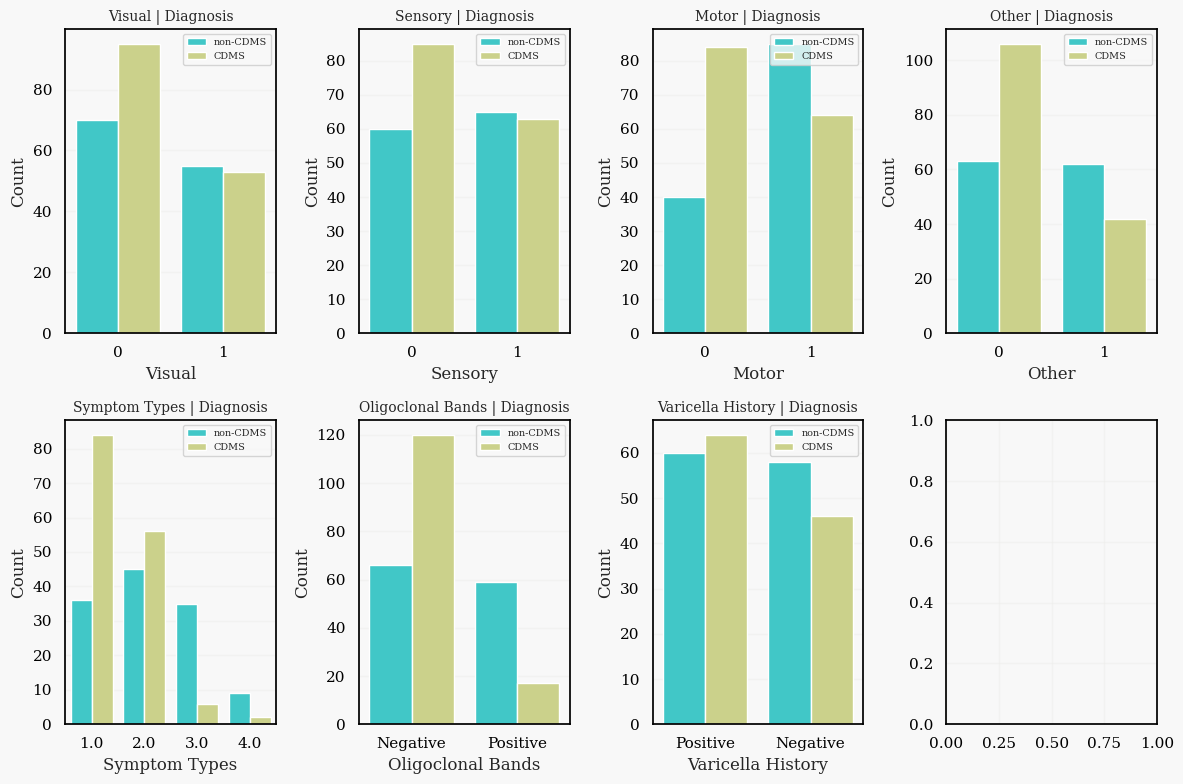

In [1582]:
fig, axs = plt.subplots(2, 4, figsize=(12, 8))

for i, ax in enumerate(axs.flatten()[:4]):
    sns.countplot(data=clinical_data, x=symptoms[i], hue="Group",ax=ax, palette="rainbow")
    ax.set_xlabel(symptoms[i])
    ax.set_ylabel("Count")
    ax.set_title(f"{symptoms[i]} | Diagnosis", fontsize=10)
    ax.legend(["non-CDMS", "CDMS"], prop={'size': 7})

sns.countplot(data=clinical_data, x="Symptom Types", hue="Group",ax=axs[1, 0], palette="rainbow")
axs[1, 0].set_xlabel("Symptom Types")
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Symptom Types | Diagnosis", fontsize=10)
axs[1, 0].legend(["non-CDMS", "CDMS"], prop={'size': 7})

sns.countplot(data=clinical_data, x="Oligoclonal Bands", hue="Group",ax=axs[1, 1], palette="rainbow")
axs[1, 1].set_xlabel("Oligoclonal Bands")
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Oligoclonal Bands | Diagnosis", fontsize=10)
axs[1, 1].legend(["non-CDMS", "CDMS"], prop={'size': 7})

sns.countplot(data=clinical_data, x="Varicella History", hue="Group",ax=axs[1, 2], palette="rainbow")
axs[1, 2].set_xlabel("Varicella History")
axs[1, 2].set_ylabel("Count")
axs[1, 2].set_title("Varicella History | Diagnosis", fontsize=10)
axs[1, 2].legend(["non-CDMS", "CDMS"], prop={'size': 7})

plt.tight_layout()
plt.show()

In [1583]:
clinical_data.head()

,ID,Varicella History,Oligoclonal Bands,Group,Initial Symptoms,Visual,Sensory,Motor,Other,Symptom Types
0,0,Positive,Negative,CDMS,sensory,0,1,0,0,1.0
1,1,Negative,Positive,CDMS,motor and other,0,0,1,1,2.0
2,2,Positive,Positive,CDMS,motor,0,0,1,0,1.0
3,3,Positive,Positive,CDMS,visual and other,1,0,0,1,2.0
4,4,Positive,Negative,CDMS,visual and motor,1,0,1,0,2.0


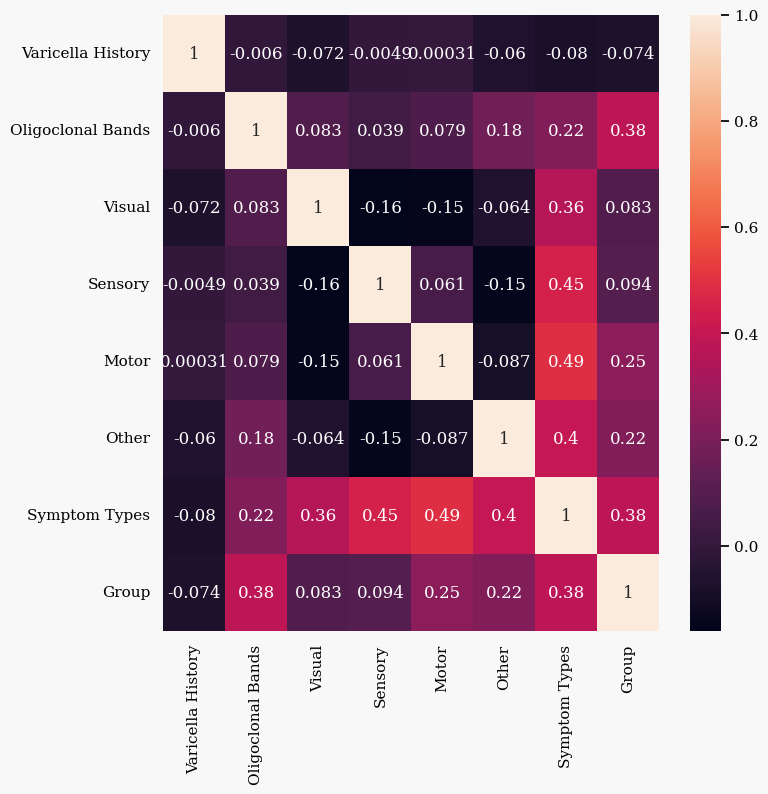

In [1584]:
group = clinical_data.pop('Group')
clinical_data['Group'] = group

f_clinical_data = clinical_data.replace({
    "non-CDMS": 0, "CDMS": 1,
    "Negative": 0, "Positive": 1
})

corr = f_clinical_data.drop(columns=["Initial Symptoms", "ID"]).corr()

fig = plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True)
plt.show()

### Electrophysiology

In [1585]:
ep_data = raw_data[["ID"] + ep_cols + ["Group"]].copy()
ep_data.head()

,ID,LLSSEP,ULSSEP,VEP,BAEP,Group
0,0,1,1,0,0,CDMS
1,1,1,0,1,0,CDMS
2,2,0,0,0,0,CDMS
3,3,0,1,1,0,CDMS
4,4,1,0,0,0,CDMS


In [1586]:
ep_data.isna().sum()

ID        0
LLSSEP    0
ULSSEP    0
VEP       0
BAEP      0
Group     0
dtype: int64

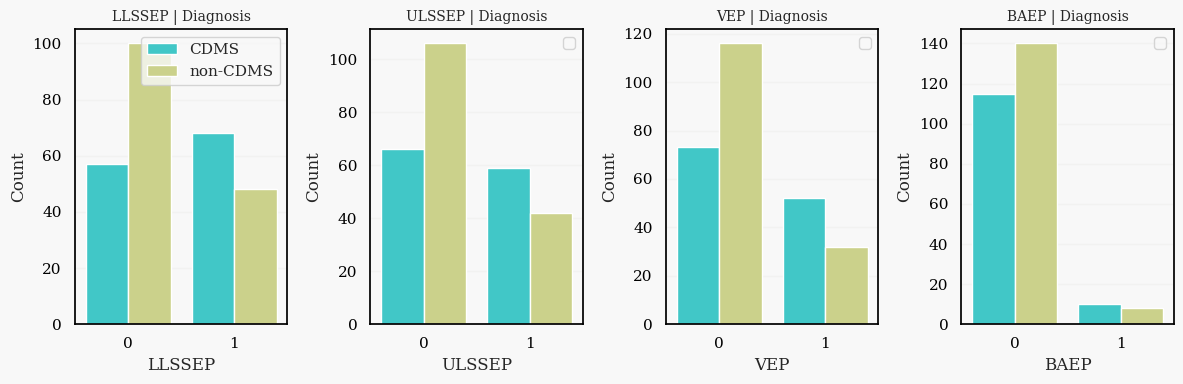

In [1587]:


fig, axs = plt.subplots(1, 4, figsize=(12, 4))
ep_cols = ['LLSSEP', 'ULSSEP', 'VEP', 'BAEP']

for i, ax in enumerate(axs.flatten()):
    sns.countplot(data=ep_data, x=ep_cols[i], hue="Group",ax=ax, palette="rainbow")
    ax.set_xlabel(ep_cols[i])
    ax.set_ylabel("Count")
    ax.set_title(f"{ep_cols[i]} | Diagnosis", fontsize=10)
    if i == 0:
        ax.legend(["CDMS", "non-CDMS"])
    else:
        ax.legend([])
        
plt.tight_layout()
plt.show()

In [1588]:
for i, row in ep_data.iterrows():
    total = 0
    for col in ep_cols:
        if row[col] == 1:
            total += 1
    
    ep_data.at[i, "Positive EP Counts"] = total
    
ep_data["Positive EP Counts"].value_counts()

Positive EP Counts
0.0    120
2.0     63
3.0     44
1.0     41
4.0      5
Name: count, dtype: int64

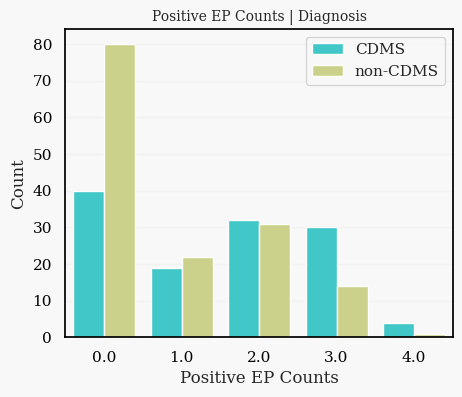

In [1589]:

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.countplot(data=ep_data, x="Positive EP Counts", hue="Group", ax=ax, palette="rainbow")
ax.set_xlabel("Positive EP Counts")
ax.set_ylabel("Count")
ax.set_title("Positive EP Counts | Diagnosis", fontsize=10)
ax.legend(["CDMS", "non-CDMS"])

plt.show()



##### Final EP Data

In [1590]:
ep_data.head()

,ID,LLSSEP,ULSSEP,VEP,BAEP,Group,Positive EP Counts
0,0,1,1,0,0,CDMS,2.0
1,1,1,0,1,0,CDMS,2.0
2,2,0,0,0,0,CDMS,0.0
3,3,0,1,1,0,CDMS,2.0
4,4,1,0,0,0,CDMS,1.0


In [1591]:
ep_data.replace({"non-CDMS":0, "CDMS": 1}, inplace=True)

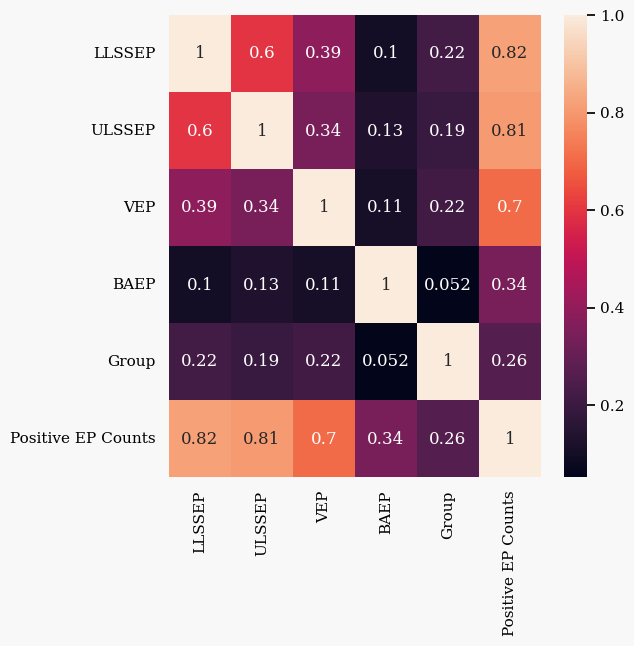

In [1592]:
corr = ep_data.drop(columns=["ID"]).corr()

fig = plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True)
plt.show()

### MRI

In [1593]:
mri_data = raw_data[["ID"] + mri_cols + ["Group"]].copy()
mri_data.head()

,ID,Periventricular MRI,Cortical MRI,Infratentorial MRI,Spinal cord MRI,Group
0,0,0,1,0,1,CDMS
1,1,0,0,0,1,CDMS
2,2,0,1,0,0,CDMS
3,3,1,1,0,0,CDMS
4,4,1,0,0,0,CDMS


In [1594]:
mri_data.isna().sum()

ID                     0
Periventricular MRI    0
Cortical MRI           0
Infratentorial MRI     0
Spinal cord MRI        0
Group                  0
dtype: int64

In [1595]:
for i, row in mri_data.iterrows():
    total = 0
    for col in mri_cols:
        if row[col] == 1:
            total += 1
    
    mri_data.at[i, "MRI Lesion Types"] = total

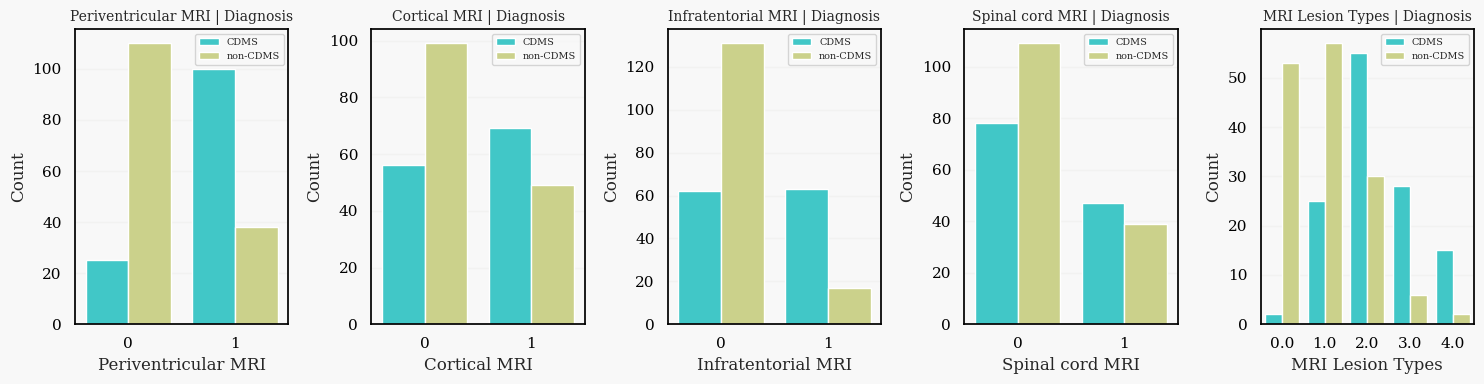

In [1596]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

new_mri_cols = mri_cols + ["MRI Lesion Types"]

for i, ax in enumerate(axs.flatten()):
    sns.countplot(data=mri_data, x=new_mri_cols[i], hue="Group", ax=ax, palette="rainbow")
    ax.set_xlabel(new_mri_cols[i])
    ax.set_ylabel("Count")
    ax.set_title(f"{new_mri_cols[i]} | Diagnosis", fontsize=10)
    ax.legend(["CDMS", "non-CDMS"], prop={'size': 7})
      
plt.tight_layout()
plt.show()

In [1597]:
mri_data.rename(columns={
    "Spinal cord MRI": "Spinal Cord MRI"
}, inplace=True)

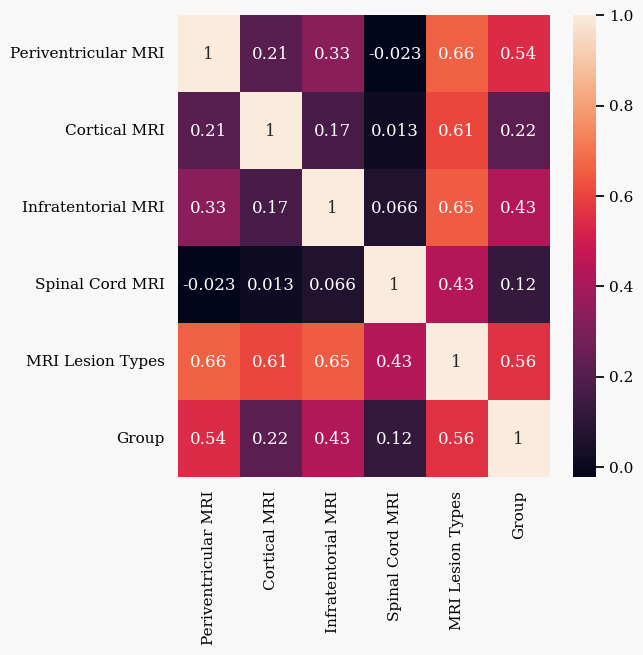

In [1598]:
group = mri_data.pop('Group')
mri_data['Group'] = group

f_mri_data = mri_data.replace({"non-CDMS":0, "CDMS": 1})

corr = f_mri_data.drop(columns=["ID"]).corr()

fig = plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True)
plt.show()

# Final Dataset

In [1599]:
from functools import reduce

all_data = [
    f_demo_data.drop(columns=["Group"]), 
    f_clinical_data.drop(columns=["Group", "Initial Symptoms"]), 
    # ep_data.drop(columns=["Group"]), 
    f_mri_data]

final_data = reduce(lambda df1, df2: pd.merge(df1, df2, on="ID", how="outer"), all_data)
final_data

,ID,Gender,Age (y),Schooling (y),Breastfeeding History,Age Group,Varicella History,Oligoclonal Bands,Visual,Sensory,Motor,Other,Symptom Types,Periventricular MRI,Cortical MRI,Infratentorial MRI,Spinal Cord MRI,MRI Lesion Types,Group
0,0,1,34,1.0,1.0,1,1.0,0.0,0,1,0,0,1.0,0,1,0,1,2.0,1
1,1,1,61,1.0,NaN,1,0.0,1.0,0,0,1,1,2.0,0,0,0,1,1.0,1
2,2,1,22,1.0,NaN,0,1.0,1.0,0,0,1,0,1.0,0,1,0,0,1.0,1
3,3,0,41,1.0,1.0,1,1.0,1.0,1,0,0,1,2.0,1,1,0,0,2.0,1
4,4,0,34,1.0,0.0,1,1.0,0.0,1,0,1,0,2.0,1,0,0,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,268,0,31,0.0,NaN,1,1.0,0.0,0,1,0,1,2.0,0,0,0,0,0.0,0
269,269,1,21,1.0,NaN,0,NaN,1.0,1,1,0,0,2.0,0,0,0,1,1.0,0
270,270,0,19,0.0,NaN,0,NaN,0.0,1,0,1,1,3.0,0,0,0,1,1.0,0
271,271,0,32,1.0,NaN,1,NaN,1.0,1,1,1,1,4.0,1,1,1,0,3.0,0


In [1600]:
t_all_data = [
    mri_data,
    demo_data.drop(columns=["Group"]), 
    clinical_data.drop(columns=["Group", "Initial Symptoms"]), 
    # ep_data.drop(columns=["Group"])
]

temp_data = reduce(lambda df1, df2: pd.merge(df1, df2, on="ID", how="outer"), t_all_data)
temp_data

,ID,Periventricular MRI,Cortical MRI,Infratentorial MRI,Spinal Cord MRI,MRI Lesion Types,Group,Gender,Age (y),Schooling (y),Breastfeeding History,Age Group,Varicella History,Oligoclonal Bands,Visual,Sensory,Motor,Other,Symptom Types
0,0,0,1,0,1,2.0,CDMS,Male,34,≥ 15 (y),Yes,≥ 30 (y),Positive,Negative,0,1,0,0,1.0
1,1,0,0,0,1,1.0,CDMS,Male,61,≥ 15 (y),NaN,≥ 30 (y),Negative,Positive,0,0,1,1,2.0
2,2,0,1,0,0,1.0,CDMS,Male,22,≥ 15 (y),NaN,< 30 (y),Positive,Positive,0,0,1,0,1.0
3,3,1,1,0,0,2.0,CDMS,Female,41,≥ 15 (y),Yes,≥ 30 (y),Positive,Positive,1,0,0,1,2.0
4,4,1,0,0,0,1.0,CDMS,Female,34,≥ 15 (y),No,≥ 30 (y),Positive,Negative,1,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,268,0,0,0,0,0.0,non-CDMS,Female,31,< 15 (y),NaN,≥ 30 (y),Positive,Negative,0,1,0,1,2.0
269,269,0,0,0,1,1.0,non-CDMS,Male,21,≥ 15 (y),NaN,< 30 (y),NaN,Positive,1,1,0,0,2.0
270,270,0,0,0,1,1.0,non-CDMS,Female,19,< 15 (y),NaN,< 30 (y),NaN,Negative,1,0,1,1,3.0
271,271,1,1,1,0,3.0,non-CDMS,Female,32,≥ 15 (y),NaN,≥ 30 (y),NaN,Positive,1,1,1,1,4.0


In [1601]:
final_data.rename(columns={
    "Age (y)": "Age",
    "Schooling (y)": "Schooling"
}, inplace=True)

In [1602]:
final_data["Group"].value_counts()

Group
0    148
1    125
Name: count, dtype: int64

In [1603]:
final_data.isna().sum()

ID                        0
Gender                    0
Age                       0
Schooling                 1
Breastfeeding History    85
Age Group                 0
Varicella History        45
Oligoclonal Bands        11
Visual                    0
Sensory                   0
Motor                     0
Other                     0
Symptom Types             0
Periventricular MRI       0
Cortical MRI              0
Infratentorial MRI        0
Spinal Cord MRI           0
MRI Lesion Types          0
Group                     0
dtype: int64

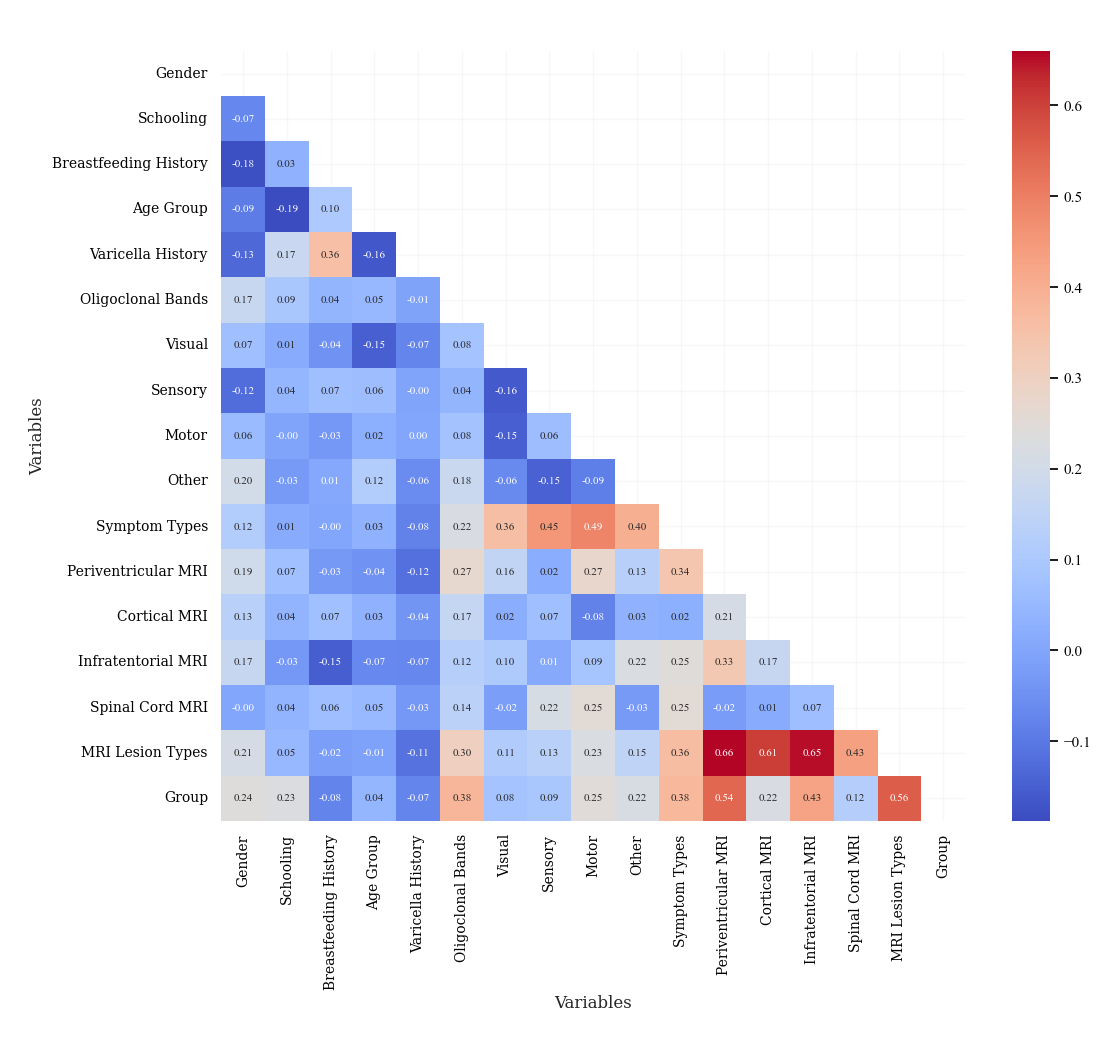

In [1604]:
corr = final_data.drop(columns=["ID", "Age"]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) 

plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, mask=mask, ax=ax) 
title = "Correlation Matrix of Study Variables"
ax.set_title("\n")
ax.set_xlabel("Variables\n")
ax.set_ylabel("\nVariables") 
ax.set_xticklabels(labels=corr.columns, rotation=90, fontsize=10)
ax.set_yticklabels(labels=corr.columns, rotation=0, fontsize=10)
plt.show()


In [1605]:
final_data.rename(columns={ "Age (y)": "Age", "Schooling (y)": "Schooling" }, inplace=True)
temp_data.rename(columns={ "Age (y)": "Age", "Schooling (y)": "Schooling" }, inplace=True)

In [1606]:
from scipy.stats import chi2_contingency
from scipy.stats import norm

cols = final_data.drop(columns=["Group", "ID", "Age"]).columns

# Function to calculate the 95% confidence interval and p-value for risk ratio
def calculate_confidence_interval_and_p_value(risk_ratio, exposed_cases, exposed_total, unexposed_cases, unexposed_total):
    log_rr = np.log(risk_ratio)
    se = np.sqrt(1 / exposed_cases - 1 / exposed_total + 1 / unexposed_cases - 1 / unexposed_total)
    z_score = log_rr / se
    lower_bound = np.exp(log_rr - 1.96 * se)
    upper_bound = np.exp(log_rr + 1.96 * se)
    return lower_bound, upper_bound


# Store results in a list of dictionaries
results = []

# Iterate through each feature column
for column in cols: 
    cross_tab = pd.crosstab(final_data[column], final_data["Group"])
    
    # Calculate Chi-Square test statistic and p-value
    chi2, p_value, _, _ = chi2_contingency(cross_tab)
    
    # Calculate risk ratio for each category in the current feature
    for category in cross_tab.index:
        event_rate_exposed = cross_tab.loc[category, 1] / (cross_tab.loc[category, 0] + cross_tab.loc[category, 1])
        event_rate_unexposed = cross_tab.drop(category).sum()[1] / (cross_tab.drop(category).sum()[0] + cross_tab.drop(category).sum()[1])
        
        risk_ratio = event_rate_exposed / event_rate_unexposed
        
        exposed_cases = cross_tab.loc[category, 1]
        exposed_total = cross_tab.loc[category].sum()
        unexposed_cases = cross_tab.drop(category).sum()[1]
        unexposed_total = cross_tab.drop(category).sum().sum()
        
        lower_bound, upper_bound = calculate_confidence_interval_and_p_value(risk_ratio, exposed_cases, exposed_total, unexposed_cases, unexposed_total)
        
        # Append results to the list
        results.append({
            'Variable': f"{column} == {category}",
            'Risk Ratio (95% CI)': f"{risk_ratio:.2f} ({lower_bound:.2f}, {upper_bound:.2f})",
            'Chi-Square': chi2,
            'p-value': round(p_value, 4)
        })

results_df = pd.DataFrame(results)
results_df

,Variable,Risk Ratio (95% CI),Chi-Square,p-value
0,Gender == 0,"0.60 (0.46, 0.77)",14.830633,0.0001
1,Gender == 1,"1.68 (1.30, 2.16)",14.830633,0.0001
2,Schooling == 0.0,"0.57 (0.41, 0.78)",13.305774,0.0003
3,Schooling == 1.0,"1.76 (1.28, 2.43)",13.305774,0.0003
4,Breastfeeding History == 0.0,"1.17 (0.88, 1.54)",0.783801,0.3760
5,Breastfeeding History == 1.0,"0.86 (0.65, 1.13)",0.783801,0.3760
6,Age Group == 0,"0.91 (0.69, 1.19)",0.356872,0.5502
7,Age Group == 1,"1.10 (0.84, 1.44)",0.356872,0.5502
8,Varicella History == 0.0,"1.15 (0.90, 1.48)",0.956518,0.3281
9,Varicella History == 1.0,"0.87 (0.68, 1.11)",0.956518,0.3281


In [1607]:
from scipy.stats import norm

cols = final_data.drop(columns=["Group", "ID", "Age"]).columns

# Function to calculate the 95% confidence interval and p-value for risk ratio
def calculate_confidence_interval_and_p_value(risk_ratio, exposed_cases, exposed_total, unexposed_cases, unexposed_total):
    log_rr = np.log(risk_ratio)
    se = np.sqrt(1 / exposed_cases - 1 / exposed_total + 1 / unexposed_cases - 1 / unexposed_total)
    z_score = log_rr / se
    p_value = 2 * (1 - norm.cdf(np.abs(z_score)))
    lower_bound = np.exp(log_rr - 1.96 * se)
    upper_bound = np.exp(log_rr + 1.96 * se)
    return lower_bound, upper_bound, p_value

# Store results in a list of dictionaries
results = []

# Iterate through each feature column
for column in cols: 
    cross_tab = pd.crosstab(final_data[column], final_data["Group"])
    
    # Calculate risk ratio, confidence interval, and p-value for each category in the current feature
    for category in cross_tab.index:
        event_rate_exposed = cross_tab.loc[category, 1] / (cross_tab.loc[category, 0] + cross_tab.loc[category, 1])
        event_rate_unexposed = cross_tab.drop(category).sum()[1] / (cross_tab.drop(category).sum()[0] + cross_tab.drop(category).sum()[1])
        
        risk_ratio = event_rate_exposed / event_rate_unexposed
        
        exposed_cases = cross_tab.loc[category, 1]
        exposed_total = cross_tab.loc[category].sum()
        unexposed_cases = cross_tab.drop(category).sum()[1]
        unexposed_total = cross_tab.drop(category).sum().sum()
        
        lower_bound, upper_bound, p_value = calculate_confidence_interval_and_p_value(risk_ratio, exposed_cases, exposed_total, unexposed_cases, unexposed_total)
        
        # Append results to the list
        results.append({
            'Variable': f"{column} == {category}",
            'Risk Ratio (95% CI)': f"{risk_ratio:.2f} ({lower_bound:.2f}, {upper_bound:.2f})",
            'p-value': f"{p_value:.4f}"
        })

results_df = pd.DataFrame(results)
results_df

,Variable,Risk Ratio (95% CI),p-value
0,Gender == 0,"0.60 (0.46, 0.77)",0.0001
1,Gender == 1,"1.68 (1.30, 2.16)",0.0001
2,Schooling == 0.0,"0.57 (0.41, 0.78)",0.0006
3,Schooling == 1.0,"1.76 (1.28, 2.43)",0.0006
4,Breastfeeding History == 0.0,"1.17 (0.88, 1.54)",0.2814
5,Breastfeeding History == 1.0,"0.86 (0.65, 1.13)",0.2814
6,Age Group == 0,"0.91 (0.69, 1.19)",0.4749
7,Age Group == 1,"1.10 (0.84, 1.44)",0.4749
8,Varicella History == 0.0,"1.15 (0.90, 1.48)",0.2650
9,Varicella History == 1.0,"0.87 (0.68, 1.11)",0.2650


In [1608]:
results = pd.DataFrame(columns=['Variable', 'Chi-square Statistic', 'P-value'])

# Perform Chi-square test
for col in cols:
    contingency_table = pd.crosstab(final_data[col], final_data['Group'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Append results to the DataFrame
    new_row = pd.DataFrame({'Variable': col, 'Chi-square Statistic': round(chi2, 2), 'P-value': p}, index=[0])
    results = pd.concat([results, new_row], ignore_index=True)

results = results.sort_values(by="P-value", ascending=True).reset_index(drop=True)
results["P-value"] = round(results["P-value"], 4)
results_s = results.style.set_properties(**{'text-align': 'left'})
results_s

,Variable,Chi-square Statistic,P-value
0,Periventricular MRI,77.850000,0.000000
1,MRI Lesion Types,90.010000,0.000000
2,Infratentorial MRI,47.670000,0.000000
3,Oligoclonal Bands,36.750000,0.000000
4,Symptom Types,43.740000,0.000000
5,Motor,15.770000,0.000100
6,Gender,14.830000,0.000100
7,Schooling,13.310000,0.000300
8,Cortical MRI,12.590000,0.000400
9,Other,12.060000,0.000500


In [1609]:
for col in results["Variable"].values:
    print(f"--------------- {blu}{col}{res} ---------------")
    p = results.loc[results['Variable'] == col, 'P-value'].iloc[0]
    print(f"P value: {red}{p: 0.4f}{res}")
    print("---------------")
    print("Value Counts:")
    if col == "Age":
        mean_age = temp_data[["Age", "Gender", "Group"]].groupby(["Group", "Gender"])["Age"].mean().to_frame()
        print(mean_age)
    else:
        count_vals = temp_data[["Group", col]].value_counts()
        print(count_vals)
        print("\n")

--------------- Periventricular MRI ---------------
P value:  0.0000
---------------
Value Counts:
Group     Periventricular MRI
non-CDMS  0                      110
CDMS      1                      100
non-CDMS  1                       38
CDMS      0                       25
Name: count, dtype: int64


--------------- MRI Lesion Types ---------------
P value:  0.0000
---------------
Value Counts:
Group     MRI Lesion Types
non-CDMS  1.0                 57
CDMS      2.0                 55
non-CDMS  0.0                 53
          2.0                 30
CDMS      3.0                 28
          1.0                 25
          4.0                 15
non-CDMS  3.0                  6
CDMS      0.0                  2
non-CDMS  4.0                  2
Name: count, dtype: int64


--------------- Infratentorial MRI ---------------
P value:  0.0000
---------------
Value Counts:
Group     Infratentorial MRI
non-CDMS  0                     131
CDMS      1                      63
          0    

In [1610]:
final_data["Group"].value_counts()

Group
0    148
1    125
Name: count, dtype: int64

In [1611]:
final_data["Symptom Types"] = final_data["Symptom Types"] - 1
temp_data["Symptom Types"] = temp_data["Symptom Types"] - 1

In [1612]:
final_data.isna().sum() / len(final_data)

ID                       0.000000
Gender                   0.000000
Age                      0.000000
Schooling                0.003663
Breastfeeding History    0.311355
Age Group                0.000000
Varicella History        0.164835
Oligoclonal Bands        0.040293
Visual                   0.000000
Sensory                  0.000000
Motor                    0.000000
Other                    0.000000
Symptom Types            0.000000
Periventricular MRI      0.000000
Cortical MRI             0.000000
Infratentorial MRI       0.000000
Spinal Cord MRI          0.000000
MRI Lesion Types         0.000000
Group                    0.000000
dtype: float64

# Data Splitting

In [1613]:
temp_data.columns

Index(['ID', 'Periventricular MRI', 'Cortical MRI', 'Infratentorial MRI',
       'Spinal Cord MRI', 'MRI Lesion Types', 'Group', 'Gender', 'Age',
       'Schooling', 'Breastfeeding History', 'Age Group', 'Varicella History',
       'Oligoclonal Bands', 'Visual', 'Sensory', 'Motor', 'Other',
       'Symptom Types'],
      dtype='object')

In [1614]:
cat_cols = ['Visual', 'Sensory', 'Motor', 'Other', 'Periventricular MRI', 'Cortical MRI', 'Infratentorial MRI',
       'Spinal Cord MRI']

temp_data[cat_cols] = temp_data[cat_cols].replace({
    0: "Negative",
    1: "Positive"
})

In [1615]:
X = final_data.drop(columns=["Group", "ID", "Age"])
y = final_data["Group"]

### Missed Values Imputation: MICE

In [1616]:
from fancyimpute import IterativeImputer

# Initialize the MICE imputer
mice_imputer = IterativeImputer()

# Perform the imputation
X_filled = mice_imputer.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_filled.round().astype(np.uint8), columns=X.columns)

In [1617]:
from sklearn.model_selection import train_test_split
seed = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)

In [1618]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv("cis2ms_train_v.csv", index=False)

# Model

### Hyperparameter tuning

In [1619]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    param = {
        'objective': 'binary:logistic',
        "max_depth": trial.suggest_int("max_depth", 2, 8, step=1),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2, step=0.03),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0, step=0.1),
        'min_child_weight': trial.suggest_int("min_child_weight", 2, 8, step=1),
        'eval_metric': 'logloss',
        'seed': seed
    }
    
    cv_results = xgb.cv(param, dtrain, num_boost_round=100, nfold=5,
                        stratified=True, shuffle=True,
                        metrics='auc', seed=seed,
                        early_stopping_rounds=10)
    
    return cv_results['test-auc-mean'].mean()

In [1620]:
from IPython.display import clear_output

def optimize(study):
    for i in range(1000):
        study.optimize(objective, n_trials=1)
        trials_df = study.trials_dataframe().drop(columns=["datetime_start", "datetime_complete", "duration", "state"])
        
        for col in trials_df.columns:
            if "params" in col:
                trials_df.rename(columns={col: col[7:]}, inplace=True)

        trials_df.drop_duplicates(
            subset=["colsample_bytree", "learning_rate", "max_depth", "min_child_weight", "subsample"],
            keep='last', inplace=True)
        
        trials_df.sort_values(by=["value"], ascending=False, inplace=True)
        trials_df.reset_index(inplace=True, drop=True)

        trials_df.rename(columns={
            "value": "auc"
        }, inplace=True)

        clear_output(wait=True)
        display(trials_df)
        

In [1621]:
# study = optuna.create_study(direction="maximize")
# optimize(study)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial

# print(f"  Value: {trial.value * 100: 0.2f}")
# print("  Params:")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

In [1622]:
# params = dict(trial.params.items())
# params["eval_metric"] = "auc"
# params["n_estimators"] = 100

In [1623]:
params = {
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "min_child_weight": 4,
    'objective': 'binary:logistic',
    'n_estimators': 100
}

### Feature importances

In [1624]:
model = XGBClassifier(**params)
model.fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# Create a DataFrame with the SHAP values and feature names
shap_df = pd.DataFrame(X_train.columns, columns=['Feature'])
shap_df['SHAP Value'] =  mean_abs_shap_values

# Sort the DataFrame by SHAP values in descending order
sorted_shap_df = shap_df.sort_values('SHAP Value', ascending=False)
sorted_shap_df["SHAP Value"] = sorted_shap_df["SHAP Value"].round(3)

sorted_shap_df.reset_index(inplace=True, drop=True)
sorted_shap_df

,Feature,SHAP Value
0,Periventricular MRI,0.899
1,Oligoclonal Bands,0.728
2,Infratentorial MRI,0.704
3,Schooling,0.660
4,Age Group,0.424
5,MRI Lesion Types,0.419
6,Symptom Types,0.313
7,Motor,0.302
8,Gender,0.297
9,Other,0.175


In [1625]:
! git clone https://github.com/drsehid/sehid_shap.git

In [1626]:
from sehid_shap.shap.plots import bar as my_bar
from sehid_shap import shap as my_shap

PermutationExplainer explainer: 205it [00:22,  5.21it/s]                         


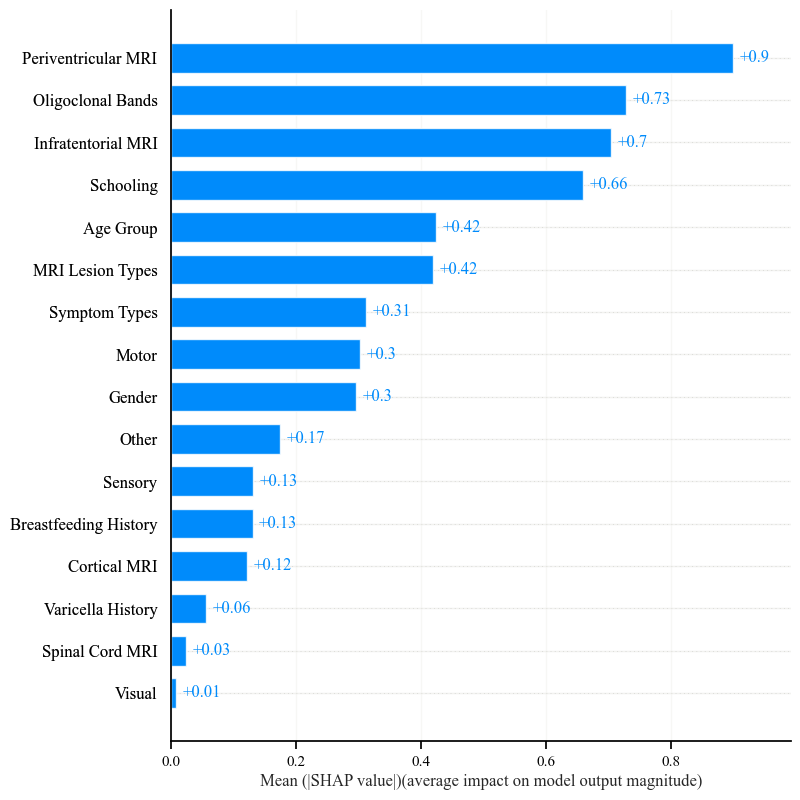

In [1627]:
model = XGBClassifier(**params)
model.fit(X_train, y_train)

shap_values = shap.TreeExplainer(model).shap_values(X_train)
explainer = my_shap.Explainer(model.predict_proba, X_train)
shap_v = explainer(X_train)

shap_v.values = shap_values

plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

title = "Average Impact of Features on Model Predictions"
fig_m = my_bar(shap_v, max_display=len(X_train.columns), 
       xlabel="Mean (|SHAP value|)(average impact on model output magnitude)", bar_color="blue", 
       font_size=12, bar_title="", title_size=14, show=False)

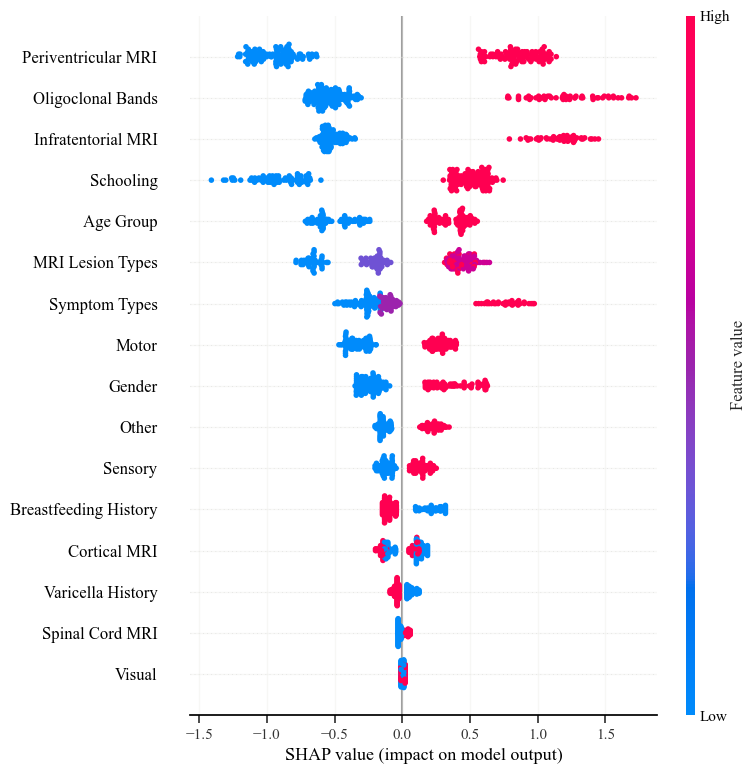

In [1628]:
model = XGBClassifier(**params)
model.fit(X_train, y_train)

tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X_train)
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
my_shap.summary_plot(shap_values, X_train, plot_type="dot")

### Adding Features from the End

In [1629]:
all_auc_scores_lh = []
all_f1_scores_lh = []
all_accuracy_scores_lh = []
all_precision_scores_lh = []
all_recall_scores_lh = []

cols = list(sorted_shap_df["Feature"])
cols.reverse()

for i in range(len(cols)):
    selected_cols = cols[:i+1]
    
    model = XGBClassifier(**params)
    
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
    
    auc_scores = []
    f1_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
        
    for train_index, test_index in rskf.split(X_train[selected_cols], y_train):
        X_train_cv, X_val_cv = X_train[selected_cols].iloc[train_index], X_train[selected_cols].iloc[test_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)

        # Make predictions
        y_pred = model.predict(X_val_cv)

        # Calculate probabilities for the positive class
        y_pred_proba = model.predict_proba(X_val_cv)[:, 1]

        # Calculate metrics
        auc = roc_auc_score(y_val_cv, y_pred_proba)
        f1 = f1_score(y_val_cv, y_pred)
        accuracy = accuracy_score(y_val_cv, y_pred)
        precision = precision_score(y_val_cv, y_pred)
        recall = recall_score(y_val_cv, y_pred)

        # Append scores
        auc_scores.append(auc)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        
    all_auc_scores_lh.append(round(np.mean(auc_scores) * 100, 1))
    all_f1_scores_lh.append(round(np.mean(f1_scores) * 100, 1))
    all_accuracy_scores_lh.append(round(np.mean(accuracy_scores) * 100, 1))
    all_precision_scores_lh.append(round(np.mean(precision_scores) * 100, 1))
    all_recall_scores_lh.append(round(np.mean(recall_scores) * 100, 1))
    
    # Print average metrics
    print(f"Feature Added: {cols[i]}")

Feature Added: Visual
Feature Added: Spinal Cord MRI
Feature Added: Varicella History
Feature Added: Cortical MRI
Feature Added: Breastfeeding History
Feature Added: Sensory
Feature Added: Other
Feature Added: Gender
Feature Added: Motor
Feature Added: Symptom Types
Feature Added: MRI Lesion Types
Feature Added: Age Group
Feature Added: Schooling
Feature Added: Infratentorial MRI
Feature Added: Oligoclonal Bands
Feature Added: Periventricular MRI


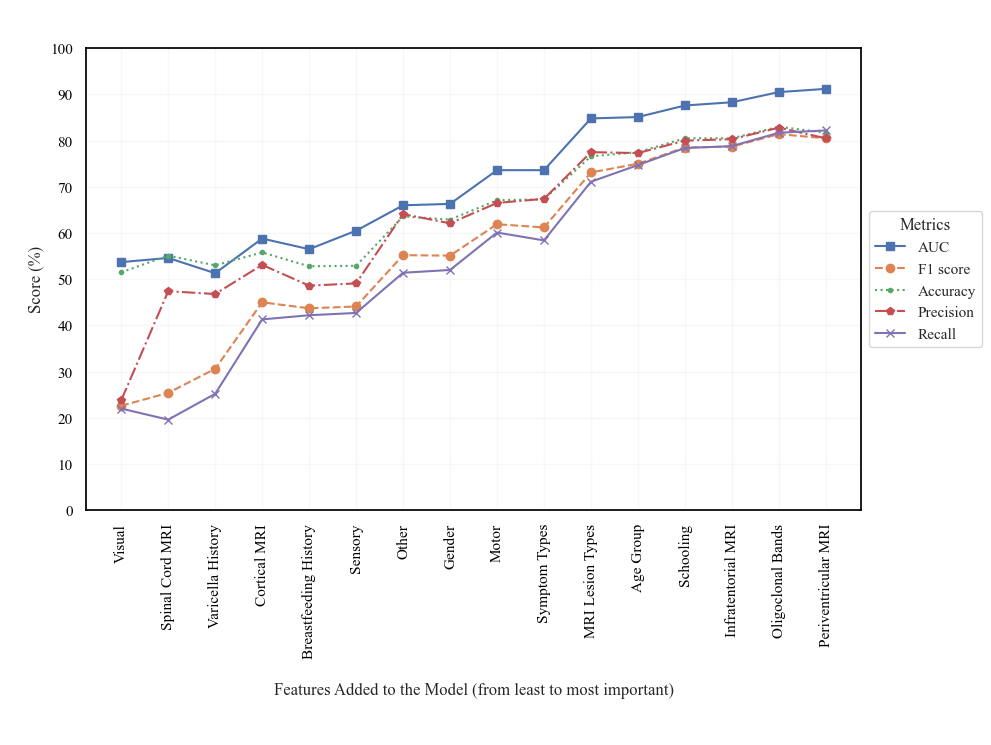

In [1630]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

auc = [None] + all_auc_scores_lh
f1 = [None] + all_f1_scores_lh
accuracy = [None] + all_accuracy_scores_lh
recall = [None] + all_recall_scores_lh
precision = [None] + all_precision_scores_lh

ax.grid(True)

ax.plot(auc, "s-", label="AUC")
ax.plot(f1, "o--", label="F1 score") 
ax.plot(accuracy, ".:", label="Accuracy")
ax.plot(precision, "p-.", label="Precision")
ax.plot(recall, "x-", label="Recall")

# Set ticks and labels
ax.set_xticks(range(1, len(cols)+1))
ax.set_xticklabels(cols, rotation=90)
ax.set_yticks(range(0, 101, 10))
ax.set_xlabel("\nFeatures Added to the Model (from least to most important)\n\n")
ax.set_ylabel("\nScore (%)")

title = "Performance Metrics of XGBClassifier with Varying Number of Features"
ax.set_title("\n", fontsize=12)

# Use a color palette and place the legend outside of the plot
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Metrics")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

fig.savefig("metrics_lh.jpeg", dpi=500, bbox_inches='tight')
plt.show()

### Selecting optimal number of features

In [1631]:
all_auc_scores_hl = []
all_f1_scores_hl = []
all_accuracy_scores_hl = []
all_precision_scores_hl = []
all_recall_scores_hl = []

cols = list(sorted_shap_df["Feature"])

for i in range(len(cols)):
    selected_cols = cols[:i+1]
    
    model = XGBClassifier(**params)
    
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
    
    auc_scores = []
    f1_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
        
    for train_index, test_index in rskf.split(X_train[selected_cols], y_train):
        X_train_cv, X_val_cv = X_train[selected_cols].iloc[train_index], X_train[selected_cols].iloc[test_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)

        # Make predictions
        y_pred = model.predict(X_val_cv)

        # Calculate probabilities for the positive class
        y_pred_proba = model.predict_proba(X_val_cv)[:, 1]

        # Calculate metrics
        auc = roc_auc_score(y_val_cv, y_pred_proba)
        f1 = f1_score(y_val_cv, y_pred)
        accuracy = accuracy_score(y_val_cv, y_pred)
        precision = precision_score(y_val_cv, y_pred)
        recall = recall_score(y_val_cv, y_pred)
        
        # Append scores
        auc_scores.append(auc)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
    
    all_auc_scores_hl.append(round(np.mean(auc_scores) * 100, 1))
    all_f1_scores_hl.append(round(np.mean(f1_scores) * 100, 1))
    all_accuracy_scores_hl.append(round(np.mean(accuracy_scores) * 100, 1))
    all_precision_scores_hl.append(round(np.mean(precision_scores) * 100, 1))
    all_recall_scores_hl.append(round(np.mean(recall_scores) * 100, 1))
    
    # Print average metrics
    print(f"Feature Added: {cols[i]}")

Feature Added: Periventricular MRI
Feature Added: Oligoclonal Bands
Feature Added: Infratentorial MRI
Feature Added: Schooling
Feature Added: Age Group
Feature Added: MRI Lesion Types
Feature Added: Symptom Types
Feature Added: Motor
Feature Added: Gender
Feature Added: Other
Feature Added: Sensory
Feature Added: Breastfeeding History
Feature Added: Cortical MRI
Feature Added: Varicella History
Feature Added: Spinal Cord MRI
Feature Added: Visual


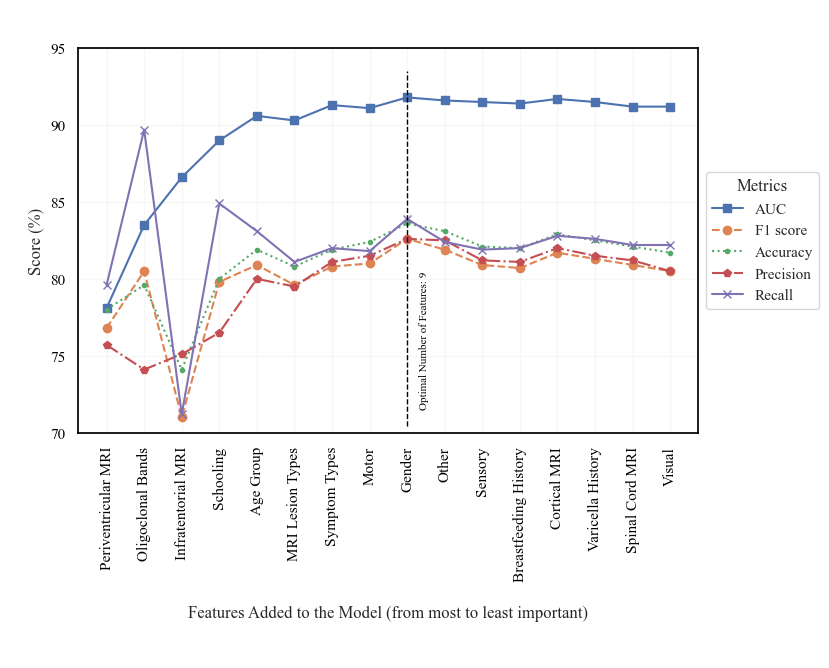

In [1632]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

auc = [None] + all_auc_scores_hl
f1 = [None] + all_f1_scores_hl
accuracy = [None] + all_accuracy_scores_hl
recall = [None] + all_recall_scores_hl
precision = [None] + all_precision_scores_hl

ax.grid(True)

ax.plot(auc, "s-", label="AUC")
ax.plot(f1, "o--", label="F1 score") 
ax.plot(accuracy, ".:", label="Accuracy")
ax.plot(precision, "p-.", label="Precision")
ax.plot(recall, "x-", label="Recall")


# Set ticks and labels
ax.set_xticks(range(1, len(cols)+1))
xticklabels = ax.set_xticklabels(cols, rotation=90)
ax.set_yticks(range(70, 96, 5))
ax.set_xlabel("\nFeatures Added to the Model (from most to least important)\n\n")
ax.set_ylabel("\nScore (%)")

optimal_features = 9
ax.axvline(x=optimal_features, color='black', linestyle='--', ymin=0.02, ymax=0.94, linewidth=1.0)
ax.text(optimal_features, 76, f'\nOptimal Number of Features: {optimal_features}', rotation=90, 
        verticalalignment='center', fontdict={"fontsize": 8, "color": "black"})

title = "Performance Metrics of XGBClassifier with Varying Number of Features"
ax.set_title("\n", fontsize=12)

# Use a color palette and place the legend outside of the plot
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Metrics")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

fig.savefig("metrics_hl.jpeg", dpi=500, bbox_inches='tight')
plt.show()

# Feature Selection

In [1633]:
final_cols = sorted_shap_df["Feature"].values[:9]
final_cols

array(['Periventricular MRI', 'Oligoclonal Bands', 'Infratentorial MRI',
       'Schooling', 'Age Group', 'MRI Lesion Types', 'Symptom Types',
       'Motor', 'Gender'], dtype=object)

### Cross-Validation with selected features

In [1634]:
model = XGBClassifier(**params)

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

auc_scores = []
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

all_y = []
all_proba = []

for train_index, test_index in rskf.split(X_train[final_cols], y_train):
    X_train_cv, X_val_cv = X_train[final_cols].iloc[train_index], X_train[final_cols].iloc[test_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model
    model.fit(X_train_cv, y_train_cv)

    # Make predictions
    y_pred = model.predict(X_val_cv)

    # Calculate probabilities for the positive class
    y_pred_proba = model.predict_proba(X_val_cv)[:, 1]
    
    all_y += list(y_val_cv)
    all_proba += list(y_pred_proba)

    # Calculate metrics
    auc = roc_auc_score(y_val_cv, y_pred_proba)
    f1 = f1_score(y_val_cv, y_pred)
    accuracy = accuracy_score(y_val_cv, y_pred)
    precision = precision_score(y_val_cv, y_pred)
    recall = recall_score(y_val_cv, y_pred)

    # Append scores
    auc_scores.append(auc)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)


# Print average metrics
print(f"Cross-Validation AUC: {round(np.mean(auc_scores) * 100, 1)}")
print(f"Cross-Validation Precison Score: {round(np.mean(precision_scores) * 100, 1)}")
print(f"Cross-Validation Recall Score: {round(np.mean(recall_scores) * 100, 1)}")
print(f"Cross-Validation F1 Score: {round(np.mean(f1_scores) * 100, 1)}")
print(f"Cross-Validation Accuracy: {round(np.mean(accuracy_scores) * 100, 1)}\n")

Cross-Validation AUC: 91.8
Cross-Validation Precison Score: 82.6
Cross-Validation Recall Score: 83.9
Cross-Validation F1 Score: 82.6
Cross-Validation Accuracy: 83.6



### Final Test Evaluation

In [1635]:
model = XGBClassifier(**params)

# Make predictions
model.fit(X_train[final_cols], y_train)
y_pred = model.predict(X_test[final_cols])

# Calculate probabilities for the positive class
y_pred_proba = model.predict_proba(X_test[final_cols])[:, 1]

# Calculate metrics
test_auc = roc_auc_score(y_test, y_pred_proba)
test_f1 = f1_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

# Print average metrics
print(f"Final Test AUC: {round(test_auc * 100, 1)}")
print(f"Final Test Precison Score: {round(np.mean(test_precision) * 100, 1)}")
print(f"Final Test Recall Score: {round(np.mean(test_recall) * 100, 1)}")
print(f"Final Test F1 Score: {round(test_f1 * 100, 1)}")
print(f"Final Test Accuracy: {round(test_accuracy * 100, 1)}\n")

Final Test AUC: 85.8
Final Test Precison Score: 77.4
Final Test Recall Score: 75.0
Final Test F1 Score: 76.2
Final Test Accuracy: 78.3



In [1636]:
from sklearn import metrics

y_cv = all_y
y_pred_cv = (np.array(all_proba) > 0.5).astype(np.uint8)


# Cross-validation metrics
accuracy_cv = metrics.accuracy_score(y_cv, y_pred_cv)
precision_cv = metrics.precision_score(y_cv, y_pred_cv)
recall_cv = metrics.recall_score(y_cv, y_pred_cv)
f1_cv = metrics.f1_score(y_cv, y_pred_cv)
tn_cv, fp_cv, fn_cv, tp_cv = metrics.confusion_matrix(y_cv, y_pred_cv).ravel()
ppv_cv = tp_cv / (tp_cv + fp_cv)
npv_cv = tn_cv / (tn_cv + fn_cv)
specificity_cv = tn_cv / (tn_cv + fp_cv)
auc_roc_cv = metrics.roc_auc_score(y_cv, all_proba)

# Test metrics
accuracy_test = metrics.accuracy_score(y_test, y_pred)
precision_test = metrics.precision_score(y_test, y_pred)
recall_test = metrics.recall_score(y_test, y_pred)
f1_test = metrics.f1_score(y_test, y_pred)
tn_test, fp_test, fn_test, tp_test = metrics.confusion_matrix(y_test, y_pred).ravel()
ppv_test = tp_test / (tp_test + fp_test)
npv_test = tn_test / (tn_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)
auc_roc_test = metrics.roc_auc_score(y_test, y_pred_proba)

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy_cv, accuracy_test],
    'AUC': [auc_roc_cv, auc_roc_test],
    'Specificity': [specificity_cv, specificity_test],
    'Recall': [recall_cv, recall_test],
    'PPV': [ppv_cv, ppv_test],
    'NPV': [npv_cv, npv_test],
    'F1 Score': [f1_cv, f1_test],
}, index=['Cross-Validation', 'Test'])


metrics_df = metrics_df.round(3).mul(100)
metrics_df

,Accuracy,AUC,Specificity,Recall,PPV,NPV,F1 Score
Cross-Validation,83.6,91.8,83.4,83.9,80.9,86.1,82.4
Test,78.3,85.8,81.1,75.0,77.4,78.9,76.2


In [1637]:
results = {
    "Accuracy(%)": [np.mean(accuracy_scores), test_accuracy],
    "AUC(%)": [np.mean(auc_scores), test_auc],
    "Precision(%)": [np.mean(precision_scores), test_precision],
    "Recall(%)": [np.mean(recall_scores), test_recall],
    "F1 Score(%)": [np.mean(f1_scores), test_f1]
}

pd.DataFrame(results, index=["Cross-Validation", "Test"]).mul(100).round(1)

,Accuracy(%),AUC(%),Precision(%),Recall(%),F1 Score(%)
Cross-Validation,83.6,91.8,82.6,83.9,82.6
Test,78.3,85.8,77.4,75.0,76.2


### Confusion Matrix

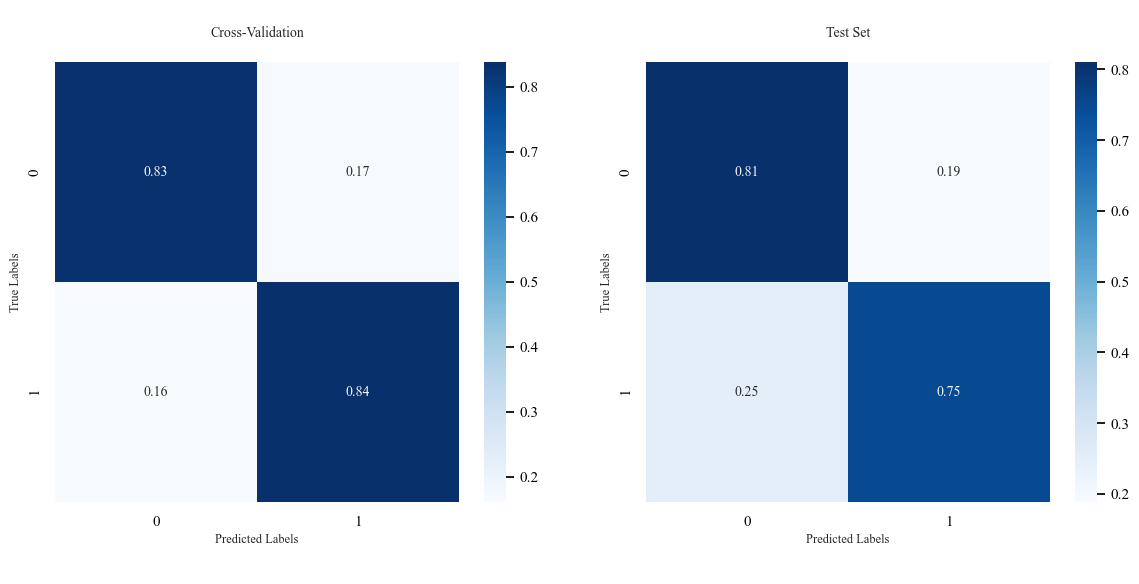

In [1638]:
from sklearn.metrics import confusion_matrix
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


cm_cv = confusion_matrix(all_y, np.array(all_proba) > 0.5)
cm_cv = cm_cv.astype('float') / cm_cv.sum(axis=1)[:, np.newaxis]

title_size = 10
label_size = 9

sns.heatmap(cm_cv, annot=True, fmt=".2f", cmap="Blues", ax=axs[0], annot_kws={"fontsize": 10})
axs[0].set_xlabel("Predicted Labels\n\n", fontsize=label_size)
axs[0].set_ylabel("True Labels", fontsize=label_size)
axs[0].set_title("\nCross-Validation\n", fontsize=title_size)


cm_test = confusion_matrix(y_test, y_pred)
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_test, annot=True, fmt=".2f", cmap="Blues", ax=axs[1], annot_kws={"fontsize": 10})
axs[1].set_xlabel("Predicted Labels\n\n", fontsize=label_size)
axs[1].set_ylabel("True Labels", fontsize=label_size)
axs[1].set_title("\nTest Set\n", fontsize=title_size)

plt.subplots_adjust(left=0.5, right=0.9)
# fig.suptitle("\nConfusion Matrix", fontsize=12)
plt.tight_layout()

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

fig.savefig("conf_matrix.jpeg", dpi=500, bbox_inches='tight')
plt.show()

In [1639]:
tn_cv, fp_cv, fn_cv, tp_cv = cm_cv.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

ppv_cv = tp_cv / (tp_cv + fp_cv)
ppv_test = tp_test / (tp_test + fp_test)

npv_cv = tn_cv / (tn_cv + fn_cv)
npv_test = tn_test / (tn_test + fn_test)



# Sensitivity or recall
sensitivity_cv = tp_cv / (tp_cv + fn_cv)
sensitivity_test = tp_test / (tp_test + fn_test)

# Specificity
specificity_cv = tn_cv / (tn_cv + fp_cv)
specificity_test = tn_test / (tn_test + fp_test)

rates = {
    "Positive Predictive Value (PPV)": [ppv_cv, ppv_test],
    "Negative Predictive Value (NPV)": [npv_cv, npv_test],
    "Sensitivity": [sensitivity_cv, sensitivity_test],
    "Specificity": [specificity_cv, specificity_test]
}

pd.DataFrame(rates, index=["Cross-Validation", "Test"]).mul(100).round(1)

,Positive Predictive Value (PPV),Negative Predictive Value (NPV),Sensitivity,Specificity
Cross-Validation,83.5,83.8,83.9,83.4
Test,79.9,76.4,75.0,81.1


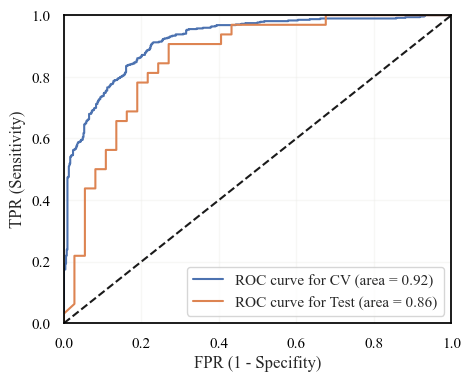

In [1640]:
from sklearn.metrics import roc_curve, roc_auc_score

# calculate scores for cross-validation set
fpr_cv, tpr_cv, thresholds_cv = roc_curve(all_y, all_proba)
roc_auc_cv = roc_auc_score(all_y, all_proba)

# calculate scores for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_proba)

# create a new figure
fig, ax = plt.subplots(figsize=(5, 4))

# plot roc curve for cross-validation set
ax.plot(fpr_cv, tpr_cv, label='ROC curve for CV (area = %0.2f)' % roc_auc_cv)

# plot roc curve for test set
ax.plot(fpr_test, tpr_test, label='ROC curve for Test (area = %0.2f)' % roc_auc_test)

# plot random predictions curve
ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('FPR (1 - Specifity)')
ax.set_ylabel('TPR (Sensitivity)')
ax.legend(loc="lower right")

# save the figure
fig.savefig("roc_curve.jpeg", dpi=500, bbox_inches='tight')

# show the plot
plt.show()

In [1641]:
# Compute Positive Predictive Value (PPV)
ppv = tp / (tp + fp)

# Compute Negative Predictive Value (NPV)
npv = tn / (tn + fn)

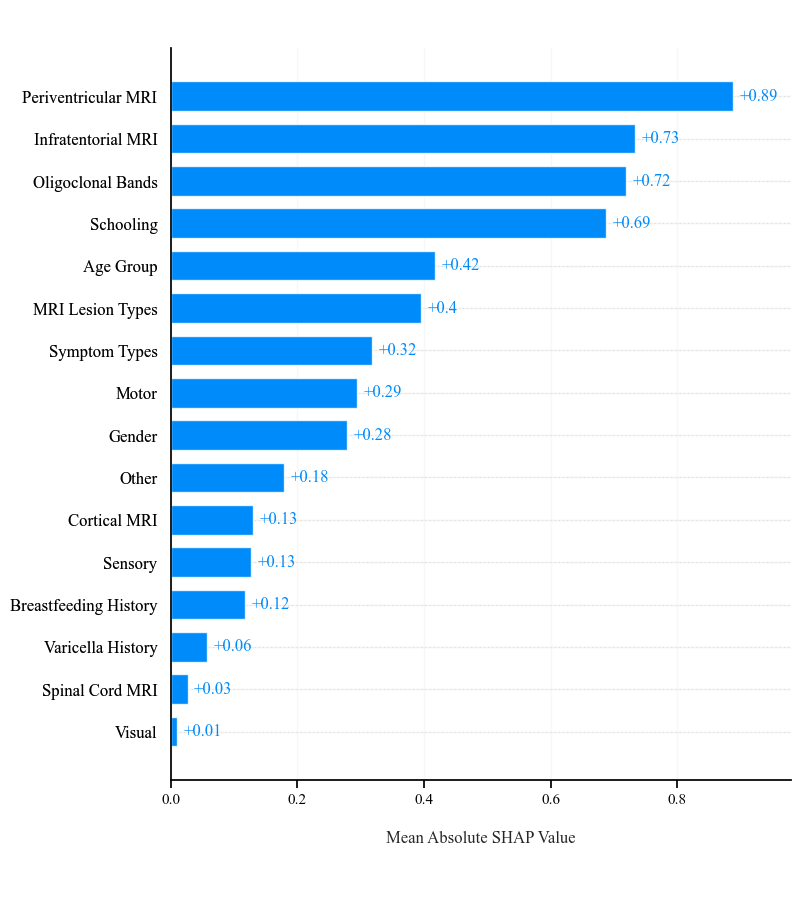

In [1642]:
model = XGBClassifier(**params)
model.fit(X_train, y_train)

shap_values = shap.TreeExplainer(model).shap_values(X_test)
explainer = my_shap.Explainer(model.predict_proba, X_test)
shap_v = explainer(X_test)

shap_v.values = shap_values


title = "Average Impact of Features on Model Predictions"
my_bar(shap_v, max_display=17, 
       xlabel="\nMean Absolute SHAP Value\n\n\n", bar_color="blue", 
       font_size=12, bar_title="\n", title_size=14)

### Shap Heatmap

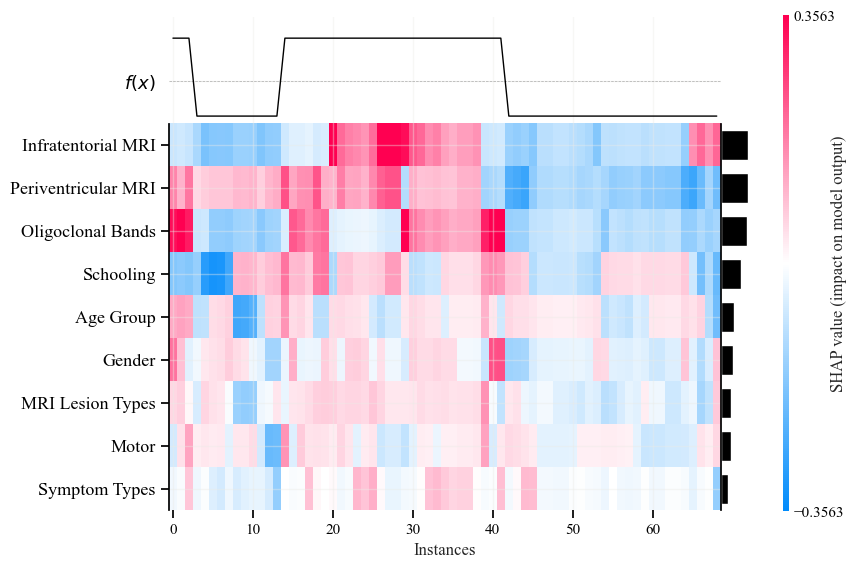

In [1643]:
model = XGBClassifier(**params)
model.fit(X_train[final_cols], y_train)

explainer_h = my_shap.Explainer(model.predict, X_test[final_cols])

shap_val = explainer_h(X_test[final_cols])

my_shap.plots.heatmap(shap_val, max_display=12)

### Tree Explainer

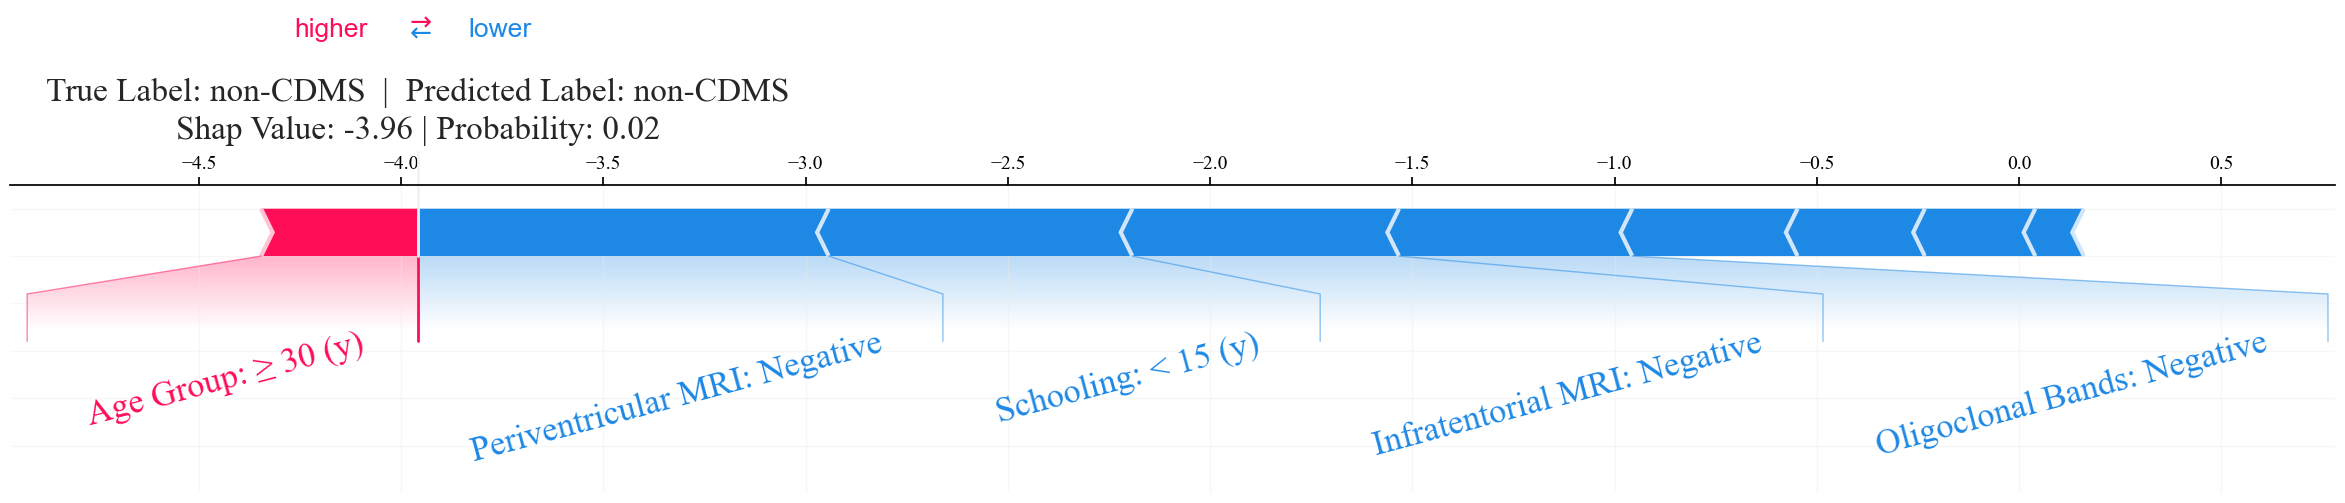

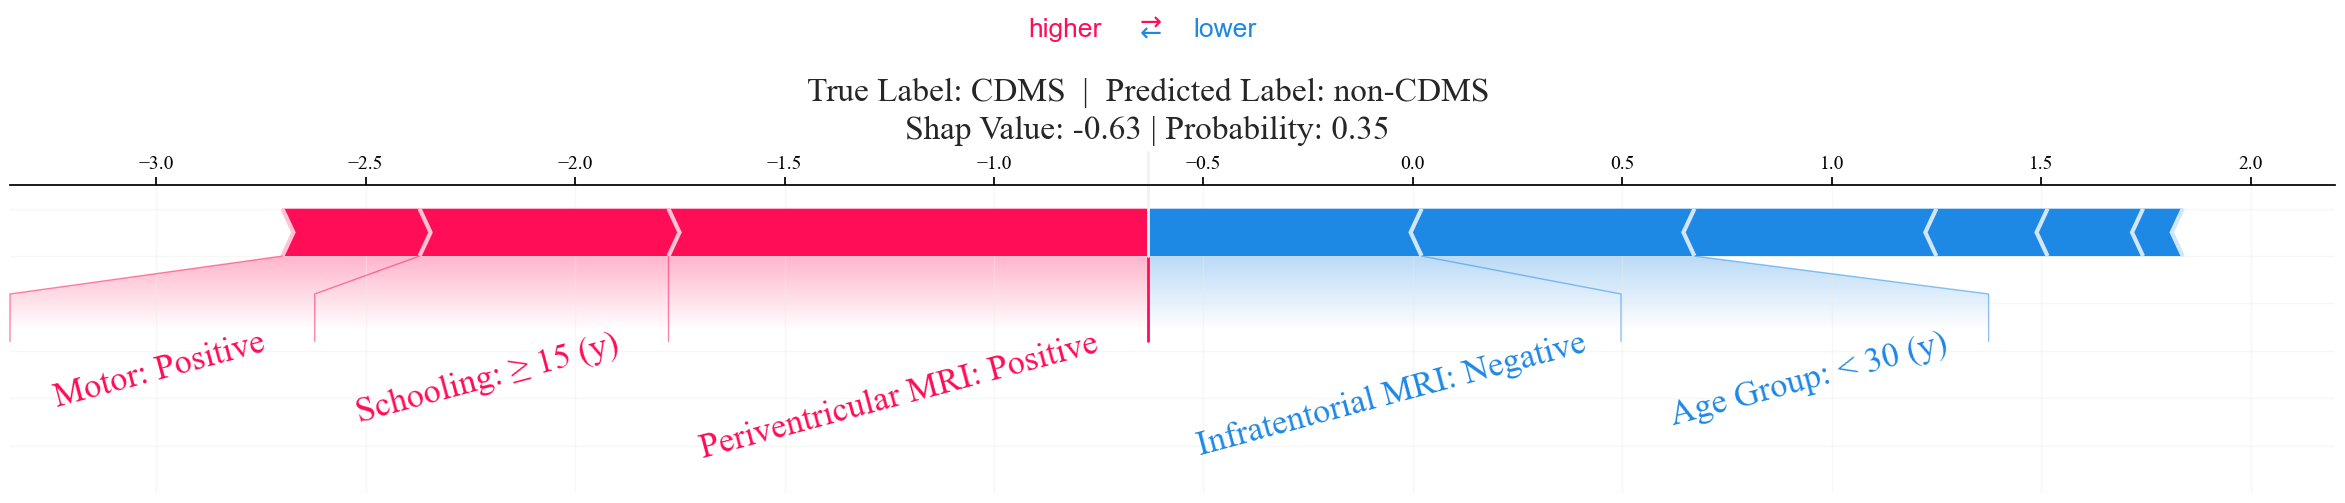

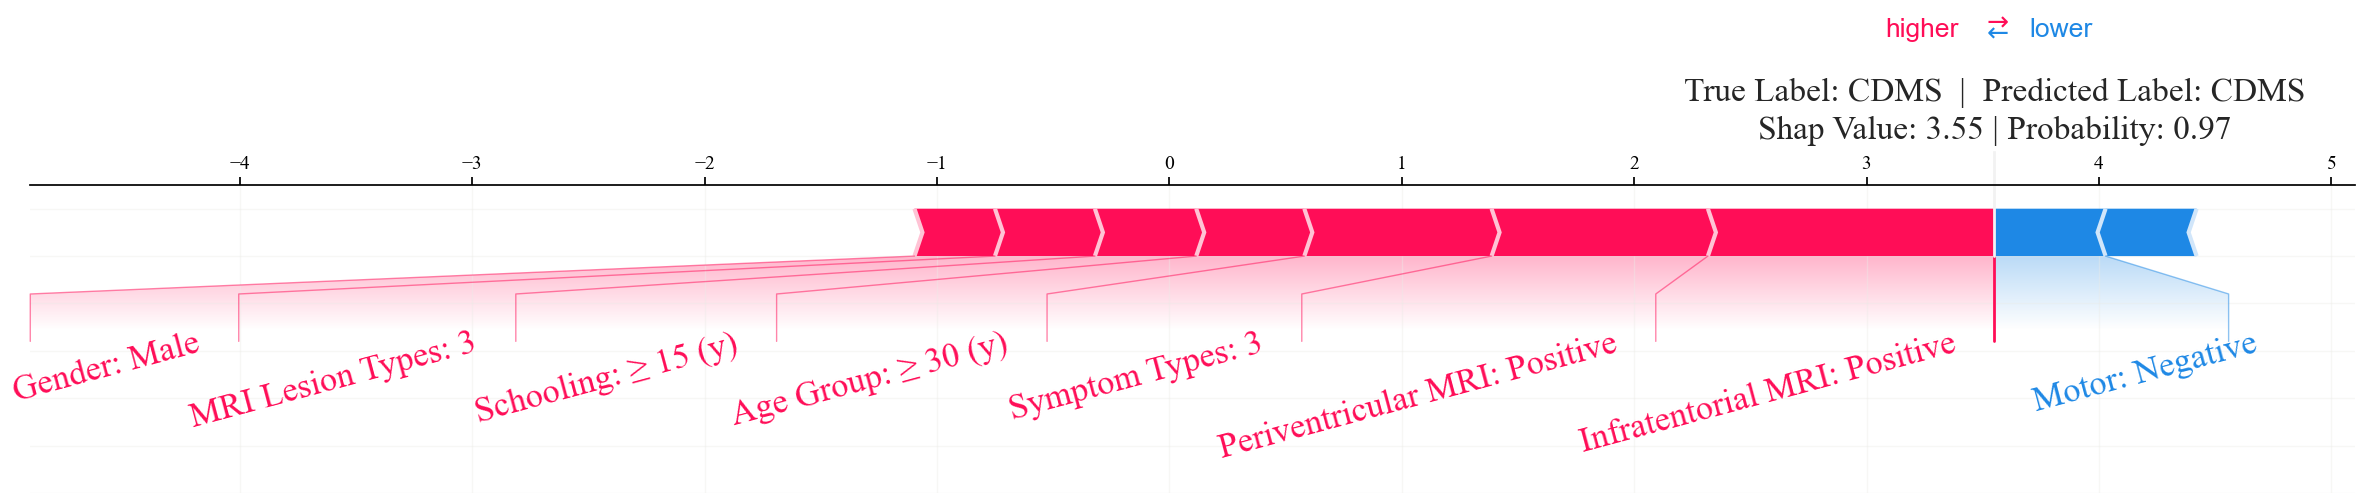

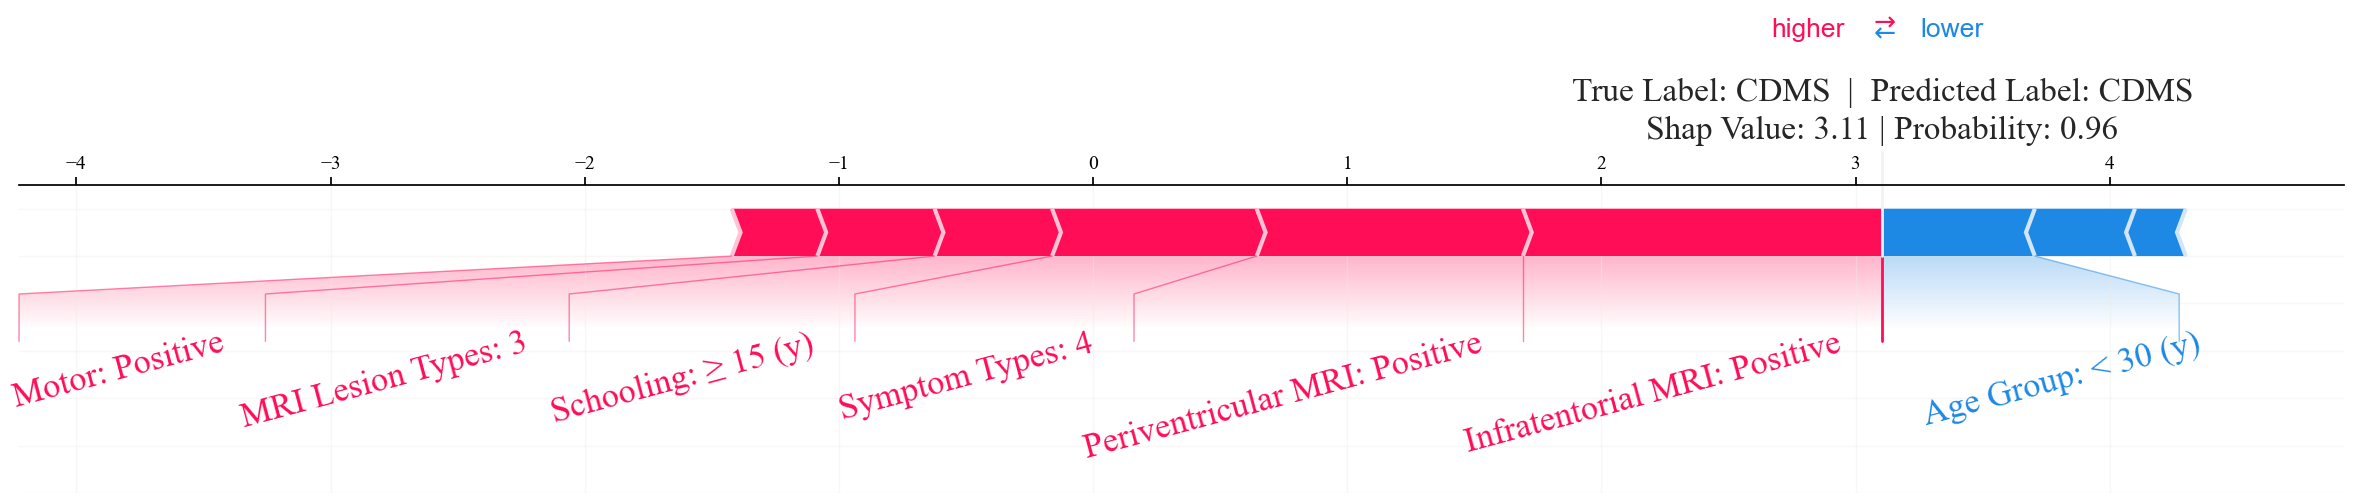

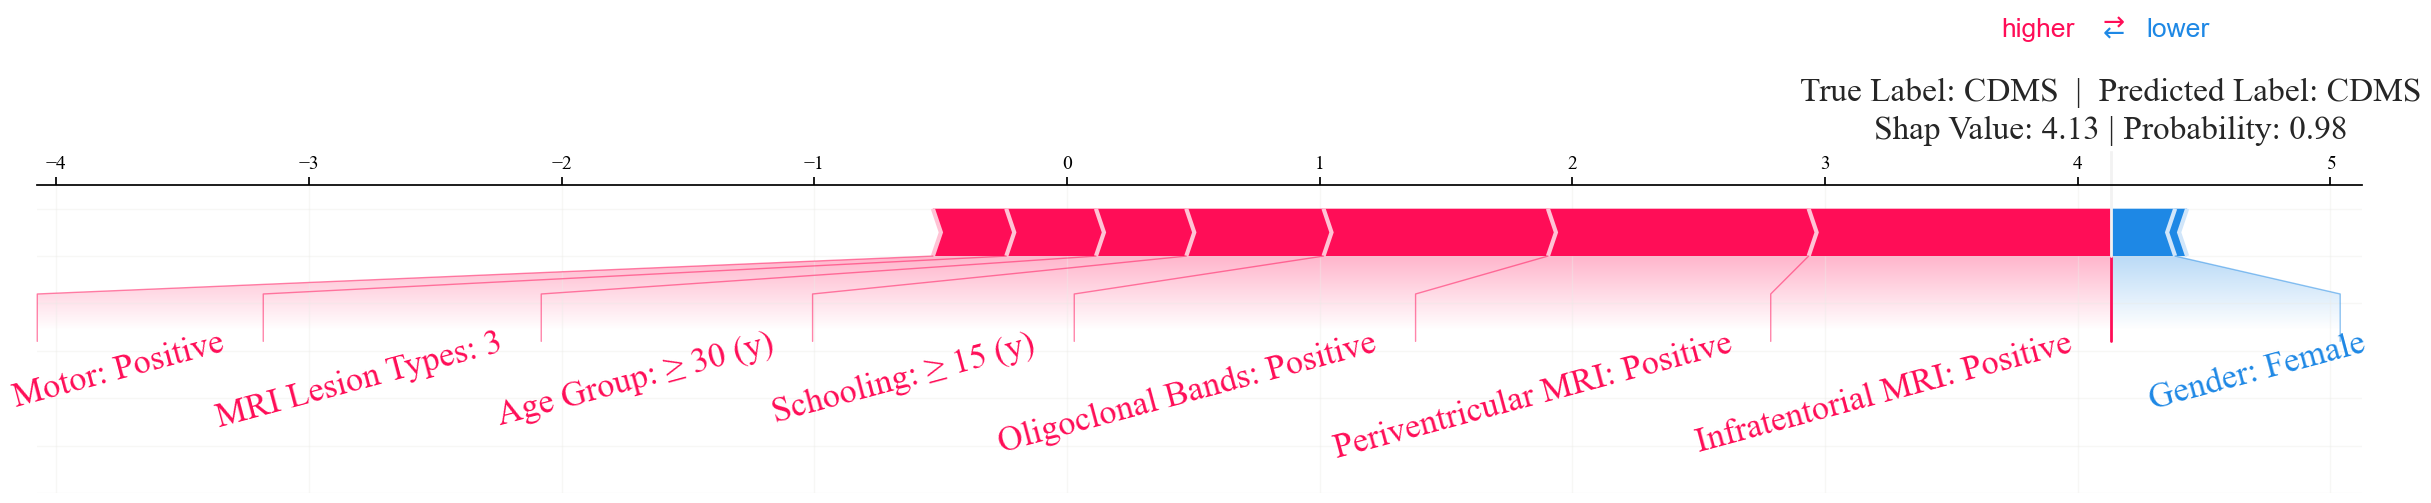

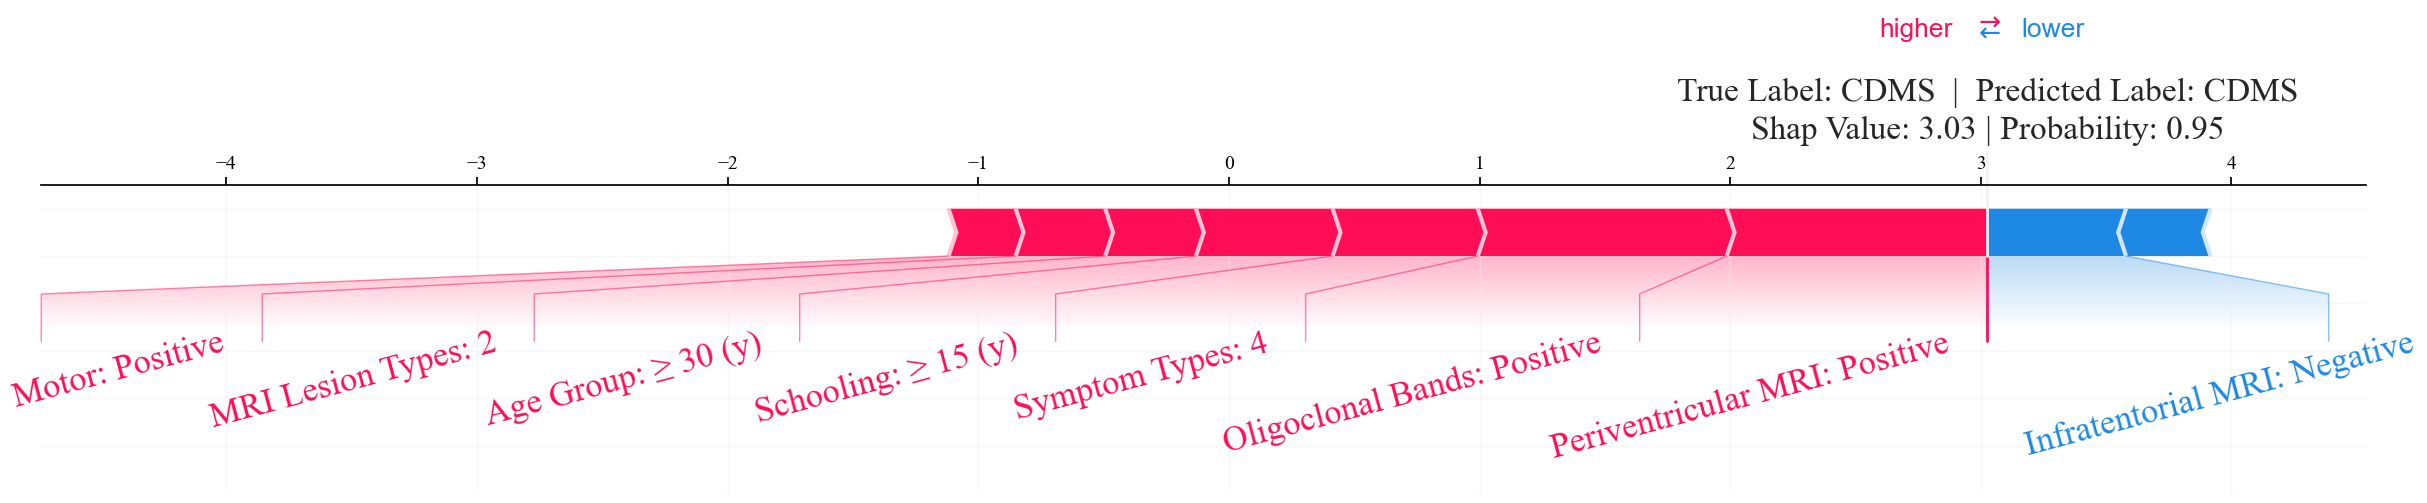

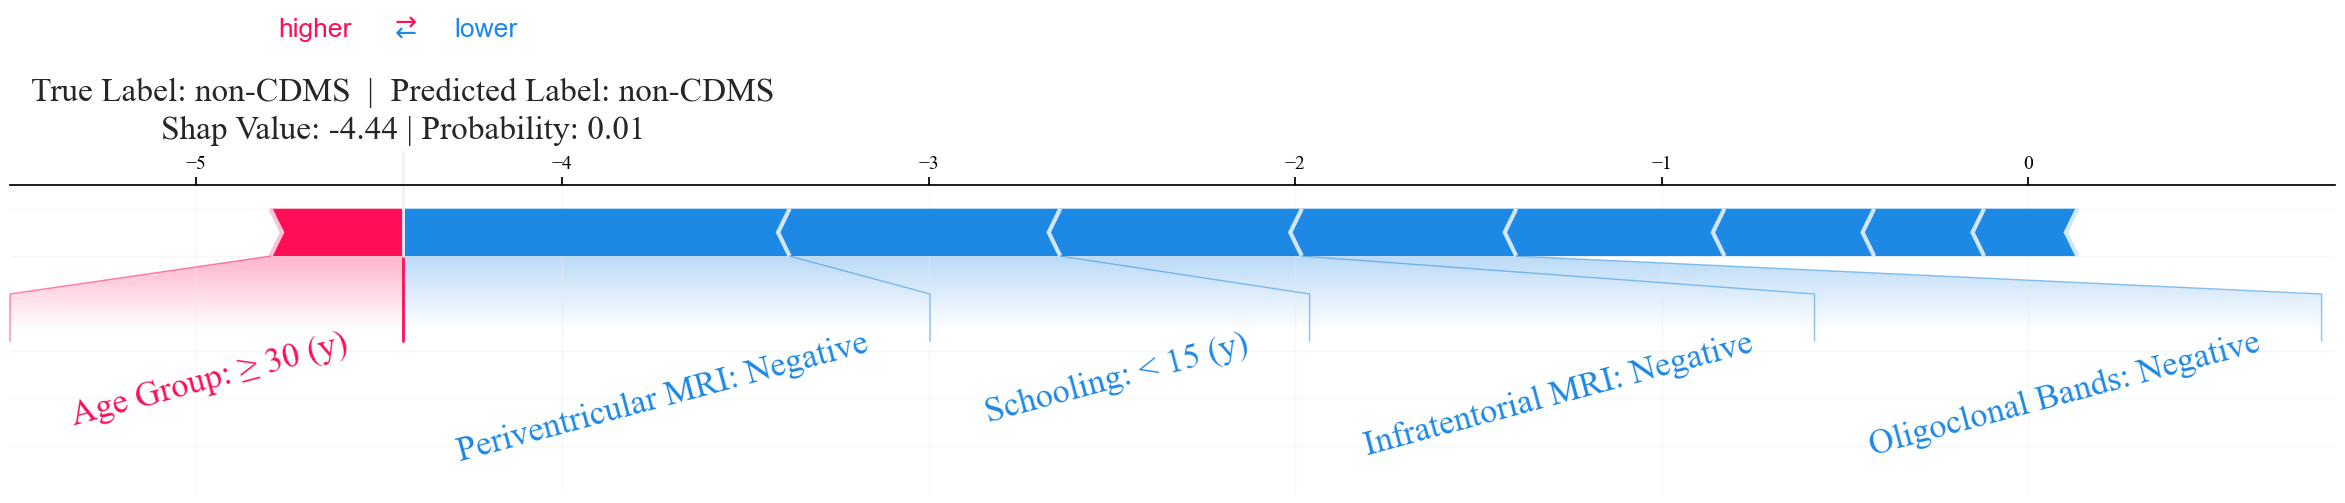

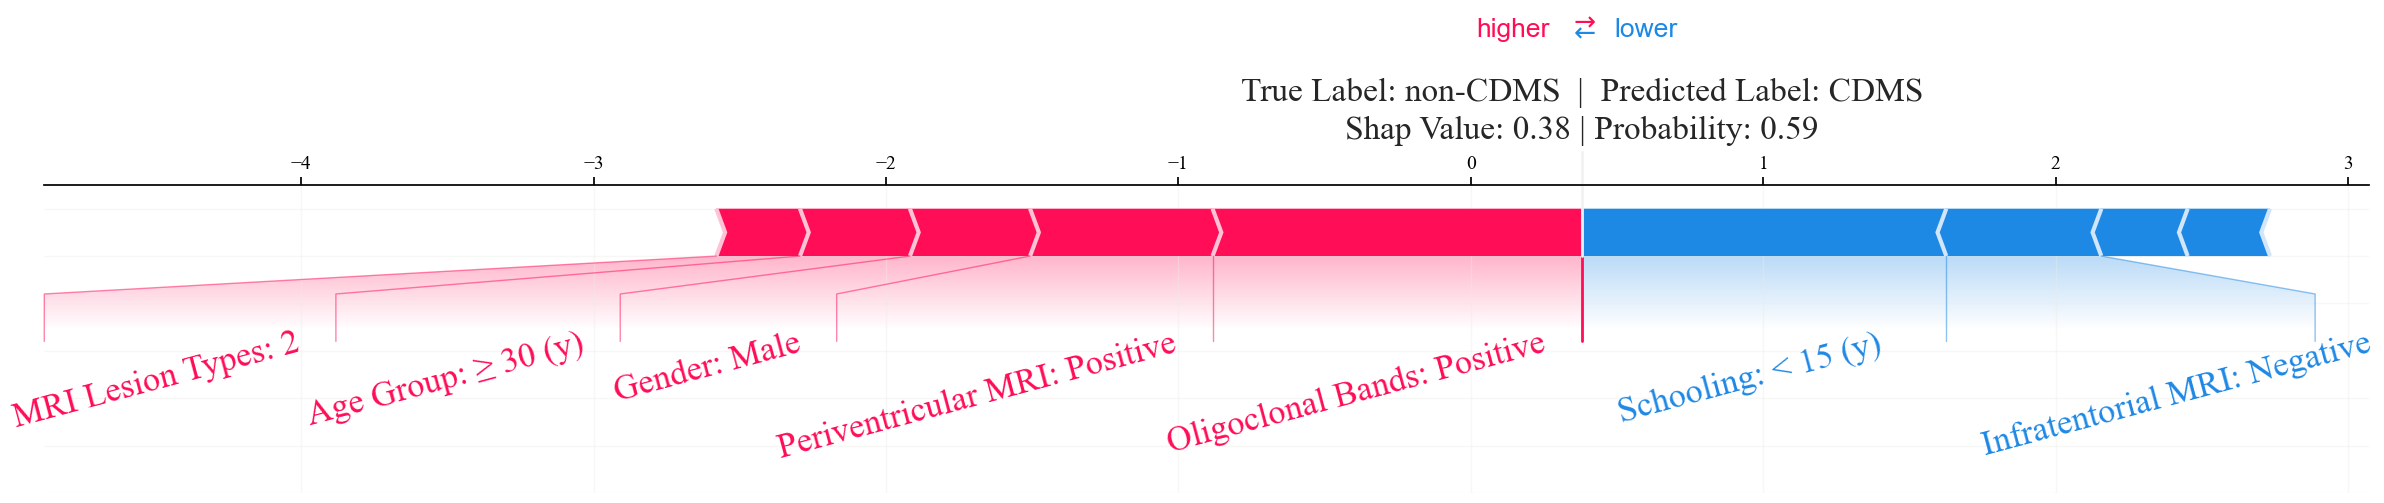

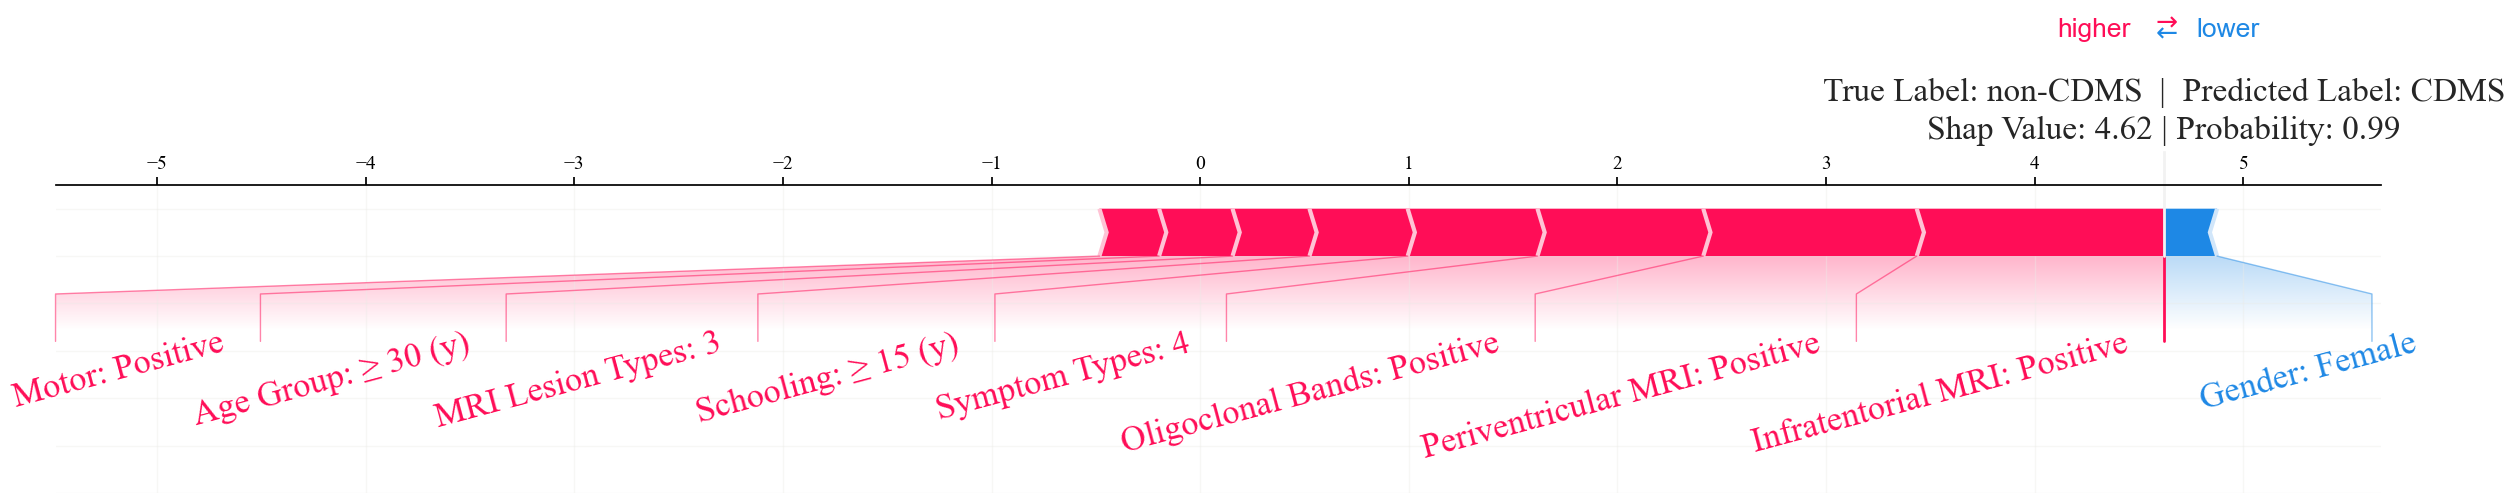

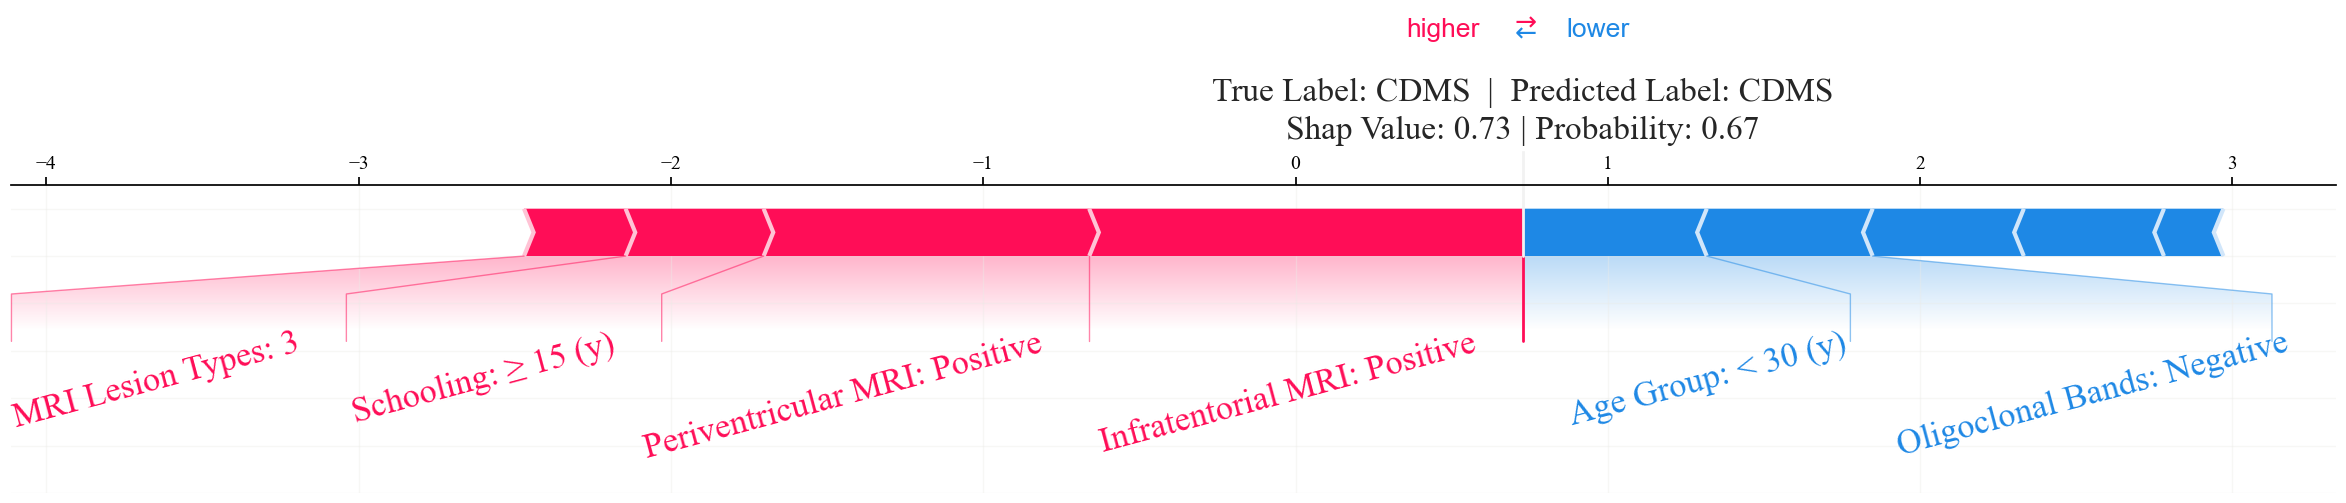

In [1644]:
explainer_raw = shap.TreeExplainer(model)
shap_values = explainer_raw.shap_values(X_test[final_cols])

bv = explainer_raw(X_test[final_cols]).base_values[2]

random_idxs = [random.randint(1, len(X_test)) for _ in range(10)]

for idx in random_idxs:
    idx_predict = model.predict(X_test[final_cols].iloc[[idx]])
    idx_proba = model.predict_proba(X_test[final_cols].iloc[[idx]])[0][1]

    sh_v = round(shap_values[idx, :].sum() + bv, 2)
    classes = ['non-CDMS', 'CDMS']
    
    # print(f"\n\nTrue Label: {mgt}{classes[y_train.iloc[idx]]}{res}")
    # print(f"Predicted Label: {mgt}{classes[idx_predict.item()]}{res} | Shap Value: {sh_v: 0.2f} | Probability: {idx_proba: 0.2f}\n")
    
    f_title = f"True Label: {classes[y_test.iloc[idx]]}  |  Predicted Label: {classes[idx_predict.item()]}"
    
    my_shap.force_plot(explainer_raw.expected_value, shap_values[idx, :],
                    X_test[final_cols].iloc[idx, :], out_names=[f_title],
                    matplotlib=True, figsize=(30, 4), plot_cmap="PkYg", text_rotation=15)

    